In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_roi_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 304)
(878801, 3)
validation
(151459, 304)
(151459, 3)
test
(112754, 304)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1001731 (3.82 MB)


Trainable params: 1001731 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 40s - loss: 1.1173 - STD: 0.1366 - MAE: 0.4295

2/9 [=====>........................] - ETA: 0s - loss: 1.1153 - STD: 0.1253 - MAE: 0.4318 

3/9 [=========>....................] - ETA: 0s - loss: 1.1184 - STD: 0.1054 - MAE: 0.4362

4/9 [============>.................] - ETA: 5s - loss: 1.1110 - STD: 0.0909 - MAE: 0.4368

5/9 [===============>..............] - ETA: 3s - loss: 1.1035 - STD: 0.0906 - MAE: 0.4357

6/9 [===================>..........] - ETA: 2s - loss: 1.1017 - STD: 0.0953 - MAE: 0.4344

7/9 [======================>.......] - ETA: 1s - loss: 1.1013 - STD: 0.0995 - MAE: 0.4335

8/9 [=========================>....] - ETA: 0s - loss: 1.0997 - STD: 0.1012 - MAE: 0.4329

9/9 [==============================] - ETA: 0s - loss: 1.0969 - STD: 0.1000 - MAE: 0.4327

9/9 [==============================] - 11s 711ms/step - loss: 1.0969 - STD: 0.1000 - MAE: 0.4327 - val_loss: 1.0713 - val_STD: 0.0686 - val_MAE: 0.4338


Epoch 2/10000


1/9 [==>...........................] - ETA: 2s - loss: 1.0712 - STD: 0.0689 - MAE: 0.4338

2/9 [=====>........................] - ETA: 0s - loss: 1.0738 - STD: 0.0629 - MAE: 0.4350

3/9 [=========>....................] - ETA: 0s - loss: 1.0765 - STD: 0.0603 - MAE: 0.4359

4/9 [============>.................] - ETA: 0s - loss: 1.0774 - STD: 0.0595 - MAE: 0.4362

5/9 [===============>..............] - ETA: 0s - loss: 1.0768 - STD: 0.0597 - MAE: 0.4360

6/9 [===================>..........] - ETA: 0s - loss: 1.0757 - STD: 0.0611 - MAE: 0.4356

7/9 [======================>.......] - ETA: 0s - loss: 1.0745 - STD: 0.0632 - MAE: 0.4351

8/9 [=========================>....] - ETA: 0s - loss: 1.0738 - STD: 0.0659 - MAE: 0.4345

9/9 [==============================] - ETA: 0s - loss: 1.0735 - STD: 0.0688 - MAE: 0.4340

9/9 [==============================] - 1s 147ms/step - loss: 1.0735 - STD: 0.0688 - MAE: 0.4340 - val_loss: 1.0695 - val_STD: 0.0938 - val_MAE: 0.4289


Epoch 3/10000


1/9 [==>...........................] - ETA: 2s - loss: 1.0685 - STD: 0.0942 - MAE: 0.4286

2/9 [=====>........................] - ETA: 1s - loss: 1.0673 - STD: 0.0933 - MAE: 0.4285

3/9 [=========>....................] - ETA: 0s - loss: 1.0657 - STD: 0.0915 - MAE: 0.4284

4/9 [============>.................] - ETA: 0s - loss: 1.0641 - STD: 0.0889 - MAE: 0.4285

5/9 [===============>..............] - ETA: 0s - loss: 1.0626 - STD: 0.0853 - MAE: 0.4288

6/9 [===================>..........] - ETA: 0s - loss: 1.0616 - STD: 0.0816 - MAE: 0.4291

7/9 [======================>.......] - ETA: 0s - loss: 1.0604 - STD: 0.0783 - MAE: 0.4293

8/9 [=========================>....] - ETA: 0s - loss: 1.0588 - STD: 0.0761 - MAE: 0.4292

9/9 [==============================] - ETA: 0s - loss: 1.0569 - STD: 0.0753 - MAE: 0.4289

9/9 [==============================] - 2s 158ms/step - loss: 1.0569 - STD: 0.0753 - MAE: 0.4289 - val_loss: 1.0371 - val_STD: 0.0750 - val_MAE: 0.4243


Epoch 4/10000


1/9 [==>...........................] - ETA: 1s - loss: 1.0345 - STD: 0.0781 - MAE: 0.4232

2/9 [=====>........................] - ETA: 0s - loss: 1.0312 - STD: 0.0809 - MAE: 0.4219

3/9 [=========>....................] - ETA: 0s - loss: 1.0273 - STD: 0.0832 - MAE: 0.4205

4/9 [============>.................] - ETA: 0s - loss: 1.0230 - STD: 0.0866 - MAE: 0.4188

5/9 [===============>..............] - ETA: 0s - loss: 1.0183 - STD: 0.0909 - MAE: 0.4168

6/9 [===================>..........] - ETA: 0s - loss: 1.0136 - STD: 0.0947 - MAE: 0.4148

7/9 [======================>.......] - ETA: 0s - loss: 1.0081 - STD: 0.0973 - MAE: 0.4130

8/9 [=========================>....] - ETA: 0s - loss: 1.0021 - STD: 0.1003 - MAE: 0.4111

9/9 [==============================] - ETA: 0s - loss: 0.9976 - STD: 0.1044 - MAE: 0.4089

9/9 [==============================] - 1s 153ms/step - loss: 0.9976 - STD: 0.1044 - MAE: 0.4089 - val_loss: 0.9583 - val_STD: 0.1309 - val_MAE: 0.3953


Epoch 5/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.9390 - STD: 0.1350 - MAE: 0.3897

2/9 [=====>........................] - ETA: 0s - loss: 0.9349 - STD: 0.1466 - MAE: 0.3853

3/9 [=========>....................] - ETA: 0s - loss: 0.9302 - STD: 0.1535 - MAE: 0.3822

4/9 [============>.................] - ETA: 0s - loss: 0.9264 - STD: 0.1613 - MAE: 0.3788

5/9 [===============>..............] - ETA: 0s - loss: 0.9235 - STD: 0.1672 - MAE: 0.3763

6/9 [===================>..........] - ETA: 0s - loss: 0.9222 - STD: 0.1755 - MAE: 0.3729

7/9 [======================>.......] - ETA: 0s - loss: 0.9219 - STD: 0.1793 - MAE: 0.3715

8/9 [=========================>....] - ETA: 0s - loss: 0.9209 - STD: 0.1856 - MAE: 0.3688

9/9 [==============================] - ETA: 0s - loss: 0.9200 - STD: 0.1898 - MAE: 0.3669

9/9 [==============================] - 1s 150ms/step - loss: 0.9200 - STD: 0.1898 - MAE: 0.3669 - val_loss: 0.9495 - val_STD: 0.2100 - val_MAE: 0.3642


Epoch 6/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.9119 - STD: 0.2093 - MAE: 0.3577

2/9 [=====>........................] - ETA: 1s - loss: 0.9085 - STD: 0.2159 - MAE: 0.3540

3/9 [=========>....................] - ETA: 0s - loss: 0.9082 - STD: 0.2197 - MAE: 0.3520

4/9 [============>.................] - ETA: 0s - loss: 0.9072 - STD: 0.2175 - MAE: 0.3527

5/9 [===============>..............] - ETA: 0s - loss: 0.9061 - STD: 0.2160 - MAE: 0.3532

6/9 [===================>..........] - ETA: 0s - loss: 0.9047 - STD: 0.2170 - MAE: 0.3525

7/9 [======================>.......] - ETA: 0s - loss: 0.9028 - STD: 0.2173 - MAE: 0.3520

8/9 [=========================>....] - ETA: 0s - loss: 0.9017 - STD: 0.2158 - MAE: 0.3525

9/9 [==============================] - ETA: 0s - loss: 0.9003 - STD: 0.2146 - MAE: 0.3528

9/9 [==============================] - 2s 153ms/step - loss: 0.9003 - STD: 0.2146 - MAE: 0.3528 - val_loss: 0.9087 - val_STD: 0.2143 - val_MAE: 0.3545


Epoch 7/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8924 - STD: 0.2099 - MAE: 0.3534

2/9 [=====>........................] - ETA: 1s - loss: 0.8888 - STD: 0.2069 - MAE: 0.3539

3/9 [=========>....................] - ETA: 0s - loss: 0.8892 - STD: 0.2023 - MAE: 0.3558

4/9 [============>.................] - ETA: 0s - loss: 0.8879 - STD: 0.1998 - MAE: 0.3565

5/9 [===============>..............] - ETA: 0s - loss: 0.8874 - STD: 0.1999 - MAE: 0.3564

6/9 [===================>..........] - ETA: 0s - loss: 0.8870 - STD: 0.2000 - MAE: 0.3563

7/9 [======================>.......] - ETA: 0s - loss: 0.8859 - STD: 0.1996 - MAE: 0.3562

8/9 [=========================>....] - ETA: 0s - loss: 0.8852 - STD: 0.1996 - MAE: 0.3560

9/9 [==============================] - ETA: 0s - loss: 0.8844 - STD: 0.2008 - MAE: 0.3554

9/9 [==============================] - 1s 149ms/step - loss: 0.8844 - STD: 0.2008 - MAE: 0.3554 - val_loss: 0.8934 - val_STD: 0.2187 - val_MAE: 0.3492


Epoch 8/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8776 - STD: 0.2141 - MAE: 0.3485

2/9 [=====>........................] - ETA: 0s - loss: 0.8759 - STD: 0.2108 - MAE: 0.3495

3/9 [=========>....................] - ETA: 0s - loss: 0.8754 - STD: 0.2116 - MAE: 0.3490

4/9 [============>.................] - ETA: 0s - loss: 0.8733 - STD: 0.2142 - MAE: 0.3474

5/9 [===============>..............] - ETA: 0s - loss: 0.8729 - STD: 0.2150 - MAE: 0.3469

6/9 [===================>..........] - ETA: 0s - loss: 0.8722 - STD: 0.2154 - MAE: 0.3466

7/9 [======================>.......] - ETA: 0s - loss: 0.8714 - STD: 0.2168 - MAE: 0.3458

8/9 [=========================>....] - ETA: 0s - loss: 0.8701 - STD: 0.2178 - MAE: 0.3451

9/9 [==============================] - ETA: 0s - loss: 0.8689 - STD: 0.2181 - MAE: 0.3447

9/9 [==============================] - 1s 147ms/step - loss: 0.8689 - STD: 0.2181 - MAE: 0.3447 - val_loss: 0.8804 - val_STD: 0.2307 - val_MAE: 0.3406


Epoch 9/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8640 - STD: 0.2268 - MAE: 0.3399

2/9 [=====>........................] - ETA: 0s - loss: 0.8607 - STD: 0.2251 - MAE: 0.3400

3/9 [=========>....................] - ETA: 0s - loss: 0.8596 - STD: 0.2241 - MAE: 0.3401

4/9 [============>.................] - ETA: 0s - loss: 0.8582 - STD: 0.2245 - MAE: 0.3397

5/9 [===============>..............] - ETA: 0s - loss: 0.8570 - STD: 0.2242 - MAE: 0.3395

6/9 [===================>..........] - ETA: 0s - loss: 0.8564 - STD: 0.2239 - MAE: 0.3395

7/9 [======================>.......] - ETA: 0s - loss: 0.8558 - STD: 0.2238 - MAE: 0.3395

8/9 [=========================>....] - ETA: 0s - loss: 0.8550 - STD: 0.2235 - MAE: 0.3394

9/9 [==============================] - ETA: 0s - loss: 0.8543 - STD: 0.2240 - MAE: 0.3391

9/9 [==============================] - 1s 147ms/step - loss: 0.8543 - STD: 0.2240 - MAE: 0.3391 - val_loss: 0.8626 - val_STD: 0.2282 - val_MAE: 0.3382


Epoch 10/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8470 - STD: 0.2211 - MAE: 0.3388

2/9 [=====>........................] - ETA: 0s - loss: 0.8458 - STD: 0.2241 - MAE: 0.3373

3/9 [=========>....................] - ETA: 0s - loss: 0.8444 - STD: 0.2250 - MAE: 0.3365

4/9 [============>.................] - ETA: 0s - loss: 0.8444 - STD: 0.2257 - MAE: 0.3362

5/9 [===============>..............] - ETA: 0s - loss: 0.8434 - STD: 0.2273 - MAE: 0.3353

6/9 [===================>..........] - ETA: 0s - loss: 0.8427 - STD: 0.2277 - MAE: 0.3350

7/9 [======================>.......] - ETA: 0s - loss: 0.8426 - STD: 0.2290 - MAE: 0.3344

8/9 [=========================>....] - ETA: 0s - loss: 0.8417 - STD: 0.2287 - MAE: 0.3343

9/9 [==============================] - ETA: 0s - loss: 0.8416 - STD: 0.2313 - MAE: 0.3331

9/9 [==============================] - 1s 150ms/step - loss: 0.8416 - STD: 0.2313 - MAE: 0.3331 - val_loss: 0.8621 - val_STD: 0.2283 - val_MAE: 0.3374


Epoch 11/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8510 - STD: 0.2182 - MAE: 0.3407

2/9 [=====>........................] - ETA: 0s - loss: 0.8478 - STD: 0.2353 - MAE: 0.3325

3/9 [=========>....................] - ETA: 0s - loss: 0.8424 - STD: 0.2329 - MAE: 0.3322

4/9 [============>.................] - ETA: 0s - loss: 0.8388 - STD: 0.2326 - MAE: 0.3317

5/9 [===============>..............] - ETA: 0s - loss: 0.8390 - STD: 0.2361 - MAE: 0.3301

6/9 [===================>..........] - ETA: 0s - loss: 0.8382 - STD: 0.2344 - MAE: 0.3308

7/9 [======================>.......] - ETA: 0s - loss: 0.8368 - STD: 0.2349 - MAE: 0.3304

8/9 [=========================>....] - ETA: 0s - loss: 0.8358 - STD: 0.2364 - MAE: 0.3295

9/9 [==============================] - ETA: 0s - loss: 0.8353 - STD: 0.2352 - MAE: 0.3299

9/9 [==============================] - 1s 144ms/step - loss: 0.8353 - STD: 0.2352 - MAE: 0.3299 - val_loss: 0.8377 - val_STD: 0.2511 - val_MAE: 0.3224


Epoch 12/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8269 - STD: 0.2403 - MAE: 0.3260

2/9 [=====>........................] - ETA: 0s - loss: 0.8278 - STD: 0.2413 - MAE: 0.3257

3/9 [=========>....................] - ETA: 0s - loss: 0.8277 - STD: 0.2371 - MAE: 0.3276

4/9 [============>.................] - ETA: 0s - loss: 0.8276 - STD: 0.2397 - MAE: 0.3264

5/9 [===============>..............] - ETA: 0s - loss: 0.8268 - STD: 0.2398 - MAE: 0.3262

6/9 [===================>..........] - ETA: 0s - loss: 0.8262 - STD: 0.2387 - MAE: 0.3265

7/9 [======================>.......] - ETA: 0s - loss: 0.8261 - STD: 0.2403 - MAE: 0.3258

8/9 [=========================>....] - ETA: 0s - loss: 0.8257 - STD: 0.2402 - MAE: 0.3258

9/9 [==============================] - ETA: 0s - loss: 0.8254 - STD: 0.2398 - MAE: 0.3259

9/9 [==============================] - 1s 159ms/step - loss: 0.8254 - STD: 0.2398 - MAE: 0.3259 - val_loss: 0.8356 - val_STD: 0.2632 - val_MAE: 0.3160


Epoch 13/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8256 - STD: 0.2524 - MAE: 0.3201

2/9 [=====>........................] - ETA: 0s - loss: 0.8252 - STD: 0.2439 - MAE: 0.3240

3/9 [=========>....................] - ETA: 0s - loss: 0.8233 - STD: 0.2451 - MAE: 0.3230

4/9 [============>.................] - ETA: 0s - loss: 0.8221 - STD: 0.2457 - MAE: 0.3224

5/9 [===============>..............] - ETA: 0s - loss: 0.8218 - STD: 0.2442 - MAE: 0.3231

6/9 [===================>..........] - ETA: 0s - loss: 0.8219 - STD: 0.2450 - MAE: 0.3227

7/9 [======================>.......] - ETA: 0s - loss: 0.8217 - STD: 0.2448 - MAE: 0.3228

8/9 [=========================>....] - ETA: 0s - loss: 0.8214 - STD: 0.2442 - MAE: 0.3230

9/9 [==============================] - ETA: 0s - loss: 0.8208 - STD: 0.2448 - MAE: 0.3226

9/9 [==============================] - 1s 145ms/step - loss: 0.8208 - STD: 0.2448 - MAE: 0.3226 - val_loss: 0.8279 - val_STD: 0.2540 - val_MAE: 0.3189


Epoch 14/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8200 - STD: 0.2421 - MAE: 0.3238

2/9 [=====>........................] - ETA: 0s - loss: 0.8182 - STD: 0.2429 - MAE: 0.3230

3/9 [=========>....................] - ETA: 0s - loss: 0.8174 - STD: 0.2456 - MAE: 0.3216

4/9 [============>.................] - ETA: 0s - loss: 0.8170 - STD: 0.2446 - MAE: 0.3220

5/9 [===============>..............] - ETA: 0s - loss: 0.8168 - STD: 0.2457 - MAE: 0.3214

6/9 [===================>..........] - ETA: 0s - loss: 0.8166 - STD: 0.2456 - MAE: 0.3214

7/9 [======================>.......] - ETA: 0s - loss: 0.8168 - STD: 0.2457 - MAE: 0.3214

8/9 [=========================>....] - ETA: 0s - loss: 0.8165 - STD: 0.2461 - MAE: 0.3211

9/9 [==============================] - ETA: 0s - loss: 0.8164 - STD: 0.2458 - MAE: 0.3213

9/9 [==============================] - 1s 143ms/step - loss: 0.8164 - STD: 0.2458 - MAE: 0.3213 - val_loss: 0.8264 - val_STD: 0.2633 - val_MAE: 0.3140


Epoch 15/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8135 - STD: 0.2514 - MAE: 0.3181

2/9 [=====>........................] - ETA: 0s - loss: 0.8150 - STD: 0.2480 - MAE: 0.3200

3/9 [=========>....................] - ETA: 0s - loss: 0.8139 - STD: 0.2491 - MAE: 0.3192

4/9 [============>.................] - ETA: 0s - loss: 0.8140 - STD: 0.2492 - MAE: 0.3192

5/9 [===============>..............] - ETA: 0s - loss: 0.8135 - STD: 0.2480 - MAE: 0.3197

6/9 [===================>..........] - ETA: 0s - loss: 0.8143 - STD: 0.2496 - MAE: 0.3191

7/9 [======================>.......] - ETA: 0s - loss: 0.8149 - STD: 0.2478 - MAE: 0.3200

8/9 [=========================>....] - ETA: 0s - loss: 0.8154 - STD: 0.2495 - MAE: 0.3193

9/9 [==============================] - ETA: 0s - loss: 0.8155 - STD: 0.2482 - MAE: 0.3199

9/9 [==============================] - 1s 151ms/step - loss: 0.8155 - STD: 0.2482 - MAE: 0.3199 - val_loss: 0.8245 - val_STD: 0.2650 - val_MAE: 0.3129


Epoch 16/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8120 - STD: 0.2529 - MAE: 0.3170

2/9 [=====>........................] - ETA: 0s - loss: 0.8104 - STD: 0.2517 - MAE: 0.3172

3/9 [=========>....................] - ETA: 0s - loss: 0.8102 - STD: 0.2485 - MAE: 0.3187

4/9 [============>.................] - ETA: 0s - loss: 0.8108 - STD: 0.2507 - MAE: 0.3178

5/9 [===============>..............] - ETA: 0s - loss: 0.8104 - STD: 0.2493 - MAE: 0.3184

6/9 [===================>..........] - ETA: 0s - loss: 0.8105 - STD: 0.2491 - MAE: 0.3185

7/9 [======================>.......] - ETA: 0s - loss: 0.8104 - STD: 0.2496 - MAE: 0.3183

8/9 [=========================>....] - ETA: 0s - loss: 0.8107 - STD: 0.2489 - MAE: 0.3187

9/9 [==============================] - ETA: 0s - loss: 0.8105 - STD: 0.2496 - MAE: 0.3183

9/9 [==============================] - 2s 162ms/step - loss: 0.8105 - STD: 0.2496 - MAE: 0.3183 - val_loss: 0.8208 - val_STD: 0.2620 - val_MAE: 0.3136


Epoch 17/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8039 - STD: 0.2499 - MAE: 0.3167

2/9 [=====>........................] - ETA: 0s - loss: 0.8076 - STD: 0.2499 - MAE: 0.3175

3/9 [=========>....................] - ETA: 0s - loss: 0.8077 - STD: 0.2504 - MAE: 0.3173

4/9 [============>.................] - ETA: 0s - loss: 0.8075 - STD: 0.2502 - MAE: 0.3173

5/9 [===============>..............] - ETA: 0s - loss: 0.8072 - STD: 0.2506 - MAE: 0.3171

6/9 [===================>..........] - ETA: 0s - loss: 0.8072 - STD: 0.2500 - MAE: 0.3174

7/9 [======================>.......] - ETA: 0s - loss: 0.8066 - STD: 0.2505 - MAE: 0.3170

8/9 [=========================>....] - ETA: 0s - loss: 0.8059 - STD: 0.2504 - MAE: 0.3170

9/9 [==============================] - ETA: 0s - loss: 0.8056 - STD: 0.2512 - MAE: 0.3165

9/9 [==============================] - 2s 165ms/step - loss: 0.8056 - STD: 0.2512 - MAE: 0.3165 - val_loss: 0.8191 - val_STD: 0.2582 - val_MAE: 0.3152


Epoch 18/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.8028 - STD: 0.2465 - MAE: 0.3181

2/9 [=====>........................] - ETA: 0s - loss: 0.8047 - STD: 0.2532 - MAE: 0.3153

3/9 [=========>....................] - ETA: 0s - loss: 0.8044 - STD: 0.2505 - MAE: 0.3165

4/9 [============>.................] - ETA: 0s - loss: 0.8041 - STD: 0.2525 - MAE: 0.3155

5/9 [===============>..............] - ETA: 0s - loss: 0.8031 - STD: 0.2523 - MAE: 0.3154

6/9 [===================>..........] - ETA: 0s - loss: 0.8027 - STD: 0.2522 - MAE: 0.3154

7/9 [======================>.......] - ETA: 0s - loss: 0.8018 - STD: 0.2527 - MAE: 0.3149

8/9 [=========================>....] - ETA: 0s - loss: 0.8018 - STD: 0.2518 - MAE: 0.3154

9/9 [==============================] - ETA: 0s - loss: 0.8022 - STD: 0.2530 - MAE: 0.3148

9/9 [==============================] - 2s 155ms/step - loss: 0.8022 - STD: 0.2530 - MAE: 0.3148 - val_loss: 0.8222 - val_STD: 0.2545 - val_MAE: 0.3177


Epoch 19/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.8059 - STD: 0.2431 - MAE: 0.3204

2/9 [=====>........................] - ETA: 0s - loss: 0.8050 - STD: 0.2559 - MAE: 0.3139

3/9 [=========>....................] - ETA: 0s - loss: 0.8035 - STD: 0.2516 - MAE: 0.3157

4/9 [============>.................] - ETA: 0s - loss: 0.8014 - STD: 0.2525 - MAE: 0.3148

5/9 [===============>..............] - ETA: 0s - loss: 0.8008 - STD: 0.2538 - MAE: 0.3141

6/9 [===================>..........] - ETA: 0s - loss: 0.8007 - STD: 0.2526 - MAE: 0.3147

7/9 [======================>.......] - ETA: 0s - loss: 0.8008 - STD: 0.2542 - MAE: 0.3139

8/9 [=========================>....] - ETA: 0s - loss: 0.8007 - STD: 0.2531 - MAE: 0.3144

9/9 [==============================] - ETA: 0s - loss: 0.7997 - STD: 0.2530 - MAE: 0.3142

9/9 [==============================] - 1s 151ms/step - loss: 0.7997 - STD: 0.2530 - MAE: 0.3142 - val_loss: 0.8157 - val_STD: 0.2763 - val_MAE: 0.3052


Epoch 20/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7996 - STD: 0.2664 - MAE: 0.3074

2/9 [=====>........................] - ETA: 1s - loss: 0.7982 - STD: 0.2559 - MAE: 0.3124

3/9 [=========>....................] - ETA: 0s - loss: 0.7982 - STD: 0.2574 - MAE: 0.3116

4/9 [============>.................] - ETA: 0s - loss: 0.7969 - STD: 0.2563 - MAE: 0.3120

5/9 [===============>..............] - ETA: 0s - loss: 0.7961 - STD: 0.2554 - MAE: 0.3123

6/9 [===================>..........] - ETA: 0s - loss: 0.7961 - STD: 0.2574 - MAE: 0.3112

7/9 [======================>.......] - ETA: 0s - loss: 0.7952 - STD: 0.2560 - MAE: 0.3117

8/9 [=========================>....] - ETA: 0s - loss: 0.7941 - STD: 0.2559 - MAE: 0.3115

9/9 [==============================] - ETA: 0s - loss: 0.7937 - STD: 0.2571 - MAE: 0.3108

9/9 [==============================] - 1s 156ms/step - loss: 0.7937 - STD: 0.2571 - MAE: 0.3108 - val_loss: 0.8163 - val_STD: 0.2632 - val_MAE: 0.3122


Epoch 21/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7953 - STD: 0.2517 - MAE: 0.3140

2/9 [=====>........................] - ETA: 0s - loss: 0.7944 - STD: 0.2588 - MAE: 0.3102

3/9 [=========>....................] - ETA: 0s - loss: 0.7913 - STD: 0.2571 - MAE: 0.3103

4/9 [============>.................] - ETA: 0s - loss: 0.7912 - STD: 0.2568 - MAE: 0.3105

5/9 [===============>..............] - ETA: 0s - loss: 0.7913 - STD: 0.2602 - MAE: 0.3087

6/9 [===================>..........] - ETA: 0s - loss: 0.7907 - STD: 0.2590 - MAE: 0.3092

7/9 [======================>.......] - ETA: 0s - loss: 0.7904 - STD: 0.2578 - MAE: 0.3097

8/9 [=========================>....] - ETA: 0s - loss: 0.7901 - STD: 0.2594 - MAE: 0.3088

9/9 [==============================] - ETA: 0s - loss: 0.7900 - STD: 0.2595 - MAE: 0.3087

9/9 [==============================] - 2s 165ms/step - loss: 0.7900 - STD: 0.2595 - MAE: 0.3087 - val_loss: 0.8054 - val_STD: 0.2680 - val_MAE: 0.3077


Epoch 22/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7833 - STD: 0.2550 - MAE: 0.3095

2/9 [=====>........................] - ETA: 0s - loss: 0.7852 - STD: 0.2602 - MAE: 0.3074

3/9 [=========>....................] - ETA: 0s - loss: 0.7855 - STD: 0.2599 - MAE: 0.3076

4/9 [============>.................] - ETA: 0s - loss: 0.7852 - STD: 0.2602 - MAE: 0.3074

5/9 [===============>..............] - ETA: 0s - loss: 0.7840 - STD: 0.2611 - MAE: 0.3067

6/9 [===================>..........] - ETA: 0s - loss: 0.7839 - STD: 0.2605 - MAE: 0.3070

7/9 [======================>.......] - ETA: 0s - loss: 0.7840 - STD: 0.2608 - MAE: 0.3068

8/9 [=========================>....] - ETA: 0s - loss: 0.7837 - STD: 0.2614 - MAE: 0.3065

9/9 [==============================] - ETA: 0s - loss: 0.7832 - STD: 0.2608 - MAE: 0.3067

9/9 [==============================] - 1s 148ms/step - loss: 0.7832 - STD: 0.2608 - MAE: 0.3067 - val_loss: 0.8026 - val_STD: 0.2757 - val_MAE: 0.3028


Epoch 23/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7782 - STD: 0.2634 - MAE: 0.3042

2/9 [=====>........................] - ETA: 0s - loss: 0.7798 - STD: 0.2655 - MAE: 0.3035

3/9 [=========>....................] - ETA: 0s - loss: 0.7806 - STD: 0.2628 - MAE: 0.3050

4/9 [============>.................] - ETA: 0s - loss: 0.7802 - STD: 0.2629 - MAE: 0.3049

5/9 [===============>..............] - ETA: 0s - loss: 0.7804 - STD: 0.2638 - MAE: 0.3045

6/9 [===================>..........] - ETA: 0s - loss: 0.7800 - STD: 0.2635 - MAE: 0.3046

7/9 [======================>.......] - ETA: 0s - loss: 0.7800 - STD: 0.2637 - MAE: 0.3044

8/9 [=========================>....] - ETA: 0s - loss: 0.7801 - STD: 0.2637 - MAE: 0.3045

9/9 [==============================] - ETA: 0s - loss: 0.7798 - STD: 0.2637 - MAE: 0.3044

9/9 [==============================] - 1s 148ms/step - loss: 0.7798 - STD: 0.2637 - MAE: 0.3044 - val_loss: 0.8035 - val_STD: 0.2822 - val_MAE: 0.2994


Epoch 24/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7767 - STD: 0.2699 - MAE: 0.3003

2/9 [=====>........................] - ETA: 0s - loss: 0.7764 - STD: 0.2658 - MAE: 0.3026

3/9 [=========>....................] - ETA: 0s - loss: 0.7777 - STD: 0.2643 - MAE: 0.3036

4/9 [============>.................] - ETA: 0s - loss: 0.7798 - STD: 0.2666 - MAE: 0.3029

5/9 [===============>..............] - ETA: 0s - loss: 0.7801 - STD: 0.2649 - MAE: 0.3039

6/9 [===================>..........] - ETA: 0s - loss: 0.7794 - STD: 0.2641 - MAE: 0.3041

7/9 [======================>.......] - ETA: 0s - loss: 0.7797 - STD: 0.2653 - MAE: 0.3035

8/9 [=========================>....] - ETA: 0s - loss: 0.7795 - STD: 0.2647 - MAE: 0.3038

9/9 [==============================] - ETA: 0s - loss: 0.7790 - STD: 0.2642 - MAE: 0.3040

9/9 [==============================] - 1s 153ms/step - loss: 0.7790 - STD: 0.2642 - MAE: 0.3040 - val_loss: 0.8002 - val_STD: 0.2813 - val_MAE: 0.2993


Epoch 25/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7776 - STD: 0.2672 - MAE: 0.3023

2/9 [=====>........................] - ETA: 0s - loss: 0.7763 - STD: 0.2652 - MAE: 0.3030

3/9 [=========>....................] - ETA: 0s - loss: 0.7746 - STD: 0.2651 - MAE: 0.3027

4/9 [============>.................] - ETA: 0s - loss: 0.7750 - STD: 0.2653 - MAE: 0.3026

5/9 [===============>..............] - ETA: 0s - loss: 0.7756 - STD: 0.2646 - MAE: 0.3031

6/9 [===================>..........] - ETA: 0s - loss: 0.7749 - STD: 0.2652 - MAE: 0.3026

7/9 [======================>.......] - ETA: 0s - loss: 0.7749 - STD: 0.2653 - MAE: 0.3026

8/9 [=========================>....] - ETA: 0s - loss: 0.7753 - STD: 0.2648 - MAE: 0.3029

9/9 [==============================] - ETA: 0s - loss: 0.7753 - STD: 0.2653 - MAE: 0.3027

9/9 [==============================] - 2s 157ms/step - loss: 0.7753 - STD: 0.2653 - MAE: 0.3027 - val_loss: 0.7981 - val_STD: 0.2784 - val_MAE: 0.3004


Epoch 26/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7741 - STD: 0.2639 - MAE: 0.3033

2/9 [=====>........................] - ETA: 0s - loss: 0.7753 - STD: 0.2632 - MAE: 0.3038

3/9 [=========>....................] - ETA: 0s - loss: 0.7769 - STD: 0.2658 - MAE: 0.3027

4/9 [============>.................] - ETA: 0s - loss: 0.7755 - STD: 0.2648 - MAE: 0.3030

5/9 [===============>..............] - ETA: 0s - loss: 0.7741 - STD: 0.2644 - MAE: 0.3030

6/9 [===================>..........] - ETA: 0s - loss: 0.7743 - STD: 0.2656 - MAE: 0.3024

7/9 [======================>.......] - ETA: 0s - loss: 0.7740 - STD: 0.2651 - MAE: 0.3026

8/9 [=========================>....] - ETA: 0s - loss: 0.7736 - STD: 0.2651 - MAE: 0.3025

9/9 [==============================] - ETA: 0s - loss: 0.7733 - STD: 0.2656 - MAE: 0.3021

9/9 [==============================] - 1s 150ms/step - loss: 0.7733 - STD: 0.2656 - MAE: 0.3021 - val_loss: 0.8000 - val_STD: 0.2776 - val_MAE: 0.3012


Epoch 27/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7742 - STD: 0.2625 - MAE: 0.3039

2/9 [=====>........................] - ETA: 0s - loss: 0.7735 - STD: 0.2655 - MAE: 0.3023

3/9 [=========>....................] - ETA: 0s - loss: 0.7715 - STD: 0.2664 - MAE: 0.3013

4/9 [============>.................] - ETA: 0s - loss: 0.7712 - STD: 0.2662 - MAE: 0.3014

5/9 [===============>..............] - ETA: 0s - loss: 0.7708 - STD: 0.2671 - MAE: 0.3009

6/9 [===================>..........] - ETA: 0s - loss: 0.7703 - STD: 0.2664 - MAE: 0.3011

7/9 [======================>.......] - ETA: 0s - loss: 0.7707 - STD: 0.2665 - MAE: 0.3012

8/9 [=========================>....] - ETA: 0s - loss: 0.7706 - STD: 0.2669 - MAE: 0.3009

9/9 [==============================] - ETA: 0s - loss: 0.7701 - STD: 0.2667 - MAE: 0.3009

9/9 [==============================] - 2s 162ms/step - loss: 0.7701 - STD: 0.2667 - MAE: 0.3009 - val_loss: 0.7932 - val_STD: 0.2819 - val_MAE: 0.2978


Epoch 28/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7693 - STD: 0.2673 - MAE: 0.3005

2/9 [=====>........................] - ETA: 1s - loss: 0.7682 - STD: 0.2670 - MAE: 0.3003

3/9 [=========>....................] - ETA: 0s - loss: 0.7681 - STD: 0.2670 - MAE: 0.3003

4/9 [============>.................] - ETA: 0s - loss: 0.7682 - STD: 0.2670 - MAE: 0.3004

5/9 [===============>..............] - ETA: 0s - loss: 0.7680 - STD: 0.2670 - MAE: 0.3003

6/9 [===================>..........] - ETA: 0s - loss: 0.7675 - STD: 0.2672 - MAE: 0.3001

7/9 [======================>.......] - ETA: 0s - loss: 0.7675 - STD: 0.2674 - MAE: 0.3000

8/9 [=========================>....] - ETA: 0s - loss: 0.7669 - STD: 0.2672 - MAE: 0.3000

9/9 [==============================] - ETA: 0s - loss: 0.7668 - STD: 0.2677 - MAE: 0.2997

9/9 [==============================] - 1s 157ms/step - loss: 0.7668 - STD: 0.2677 - MAE: 0.2997 - val_loss: 0.7918 - val_STD: 0.2829 - val_MAE: 0.2968


Epoch 29/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7679 - STD: 0.2677 - MAE: 0.3000

2/9 [=====>........................] - ETA: 0s - loss: 0.7665 - STD: 0.2670 - MAE: 0.3000

3/9 [=========>....................] - ETA: 0s - loss: 0.7649 - STD: 0.2694 - MAE: 0.2985

4/9 [============>.................] - ETA: 0s - loss: 0.7652 - STD: 0.2685 - MAE: 0.2990

5/9 [===============>..............] - ETA: 0s - loss: 0.7642 - STD: 0.2686 - MAE: 0.2987

6/9 [===================>..........] - ETA: 0s - loss: 0.7639 - STD: 0.2691 - MAE: 0.2984

7/9 [======================>.......] - ETA: 0s - loss: 0.7641 - STD: 0.2688 - MAE: 0.2986

8/9 [=========================>....] - ETA: 0s - loss: 0.7643 - STD: 0.2685 - MAE: 0.2988

9/9 [==============================] - ETA: 0s - loss: 0.7643 - STD: 0.2690 - MAE: 0.2985

9/9 [==============================] - 1s 160ms/step - loss: 0.7643 - STD: 0.2690 - MAE: 0.2985 - val_loss: 0.7904 - val_STD: 0.2830 - val_MAE: 0.2964


Epoch 30/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7644 - STD: 0.2674 - MAE: 0.2994

2/9 [=====>........................] - ETA: 0s - loss: 0.7648 - STD: 0.2675 - MAE: 0.2994

3/9 [=========>....................] - ETA: 0s - loss: 0.7635 - STD: 0.2690 - MAE: 0.2984

4/9 [============>.................] - ETA: 0s - loss: 0.7625 - STD: 0.2688 - MAE: 0.2983

5/9 [===============>..............] - ETA: 0s - loss: 0.7617 - STD: 0.2689 - MAE: 0.2981

6/9 [===================>..........] - ETA: 0s - loss: 0.7615 - STD: 0.2695 - MAE: 0.2978

7/9 [======================>.......] - ETA: 0s - loss: 0.7615 - STD: 0.2691 - MAE: 0.2979

8/9 [=========================>....] - ETA: 0s - loss: 0.7615 - STD: 0.2693 - MAE: 0.2978

9/9 [==============================] - ETA: 0s - loss: 0.7615 - STD: 0.2697 - MAE: 0.2976

9/9 [==============================] - 1s 156ms/step - loss: 0.7615 - STD: 0.2697 - MAE: 0.2976 - val_loss: 0.7859 - val_STD: 0.2843 - val_MAE: 0.2951


Epoch 31/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7600 - STD: 0.2690 - MAE: 0.2978

2/9 [=====>........................] - ETA: 0s - loss: 0.7607 - STD: 0.2687 - MAE: 0.2981

3/9 [=========>....................] - ETA: 0s - loss: 0.7604 - STD: 0.2711 - MAE: 0.2968

4/9 [============>.................] - ETA: 0s - loss: 0.7610 - STD: 0.2698 - MAE: 0.2976

5/9 [===============>..............] - ETA: 0s - loss: 0.7613 - STD: 0.2702 - MAE: 0.2974

6/9 [===================>..........] - ETA: 0s - loss: 0.7618 - STD: 0.2706 - MAE: 0.2973

7/9 [======================>.......] - ETA: 0s - loss: 0.7614 - STD: 0.2706 - MAE: 0.2972

8/9 [=========================>....] - ETA: 0s - loss: 0.7610 - STD: 0.2704 - MAE: 0.2972

9/9 [==============================] - ETA: 0s - loss: 0.7602 - STD: 0.2707 - MAE: 0.2969

9/9 [==============================] - 2s 169ms/step - loss: 0.7602 - STD: 0.2707 - MAE: 0.2969 - val_loss: 0.7829 - val_STD: 0.2837 - val_MAE: 0.2949


Epoch 32/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7561 - STD: 0.2680 - MAE: 0.2973

2/9 [=====>........................] - ETA: 0s - loss: 0.7559 - STD: 0.2702 - MAE: 0.2962

3/9 [=========>....................] - ETA: 0s - loss: 0.7568 - STD: 0.2705 - MAE: 0.2963

4/9 [============>.................] - ETA: 0s - loss: 0.7571 - STD: 0.2703 - MAE: 0.2965

5/9 [===============>..............] - ETA: 0s - loss: 0.7570 - STD: 0.2710 - MAE: 0.2961

6/9 [===================>..........] - ETA: 0s - loss: 0.7569 - STD: 0.2709 - MAE: 0.2962

7/9 [======================>.......] - ETA: 0s - loss: 0.7570 - STD: 0.2711 - MAE: 0.2961

8/9 [=========================>....] - ETA: 0s - loss: 0.7571 - STD: 0.2711 - MAE: 0.2961

9/9 [==============================] - ETA: 0s - loss: 0.7566 - STD: 0.2714 - MAE: 0.2959

9/9 [==============================] - 1s 151ms/step - loss: 0.7566 - STD: 0.2714 - MAE: 0.2959 - val_loss: 0.7842 - val_STD: 0.2856 - val_MAE: 0.2938


Epoch 33/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7540 - STD: 0.2706 - MAE: 0.2957

2/9 [=====>........................] - ETA: 0s - loss: 0.7550 - STD: 0.2723 - MAE: 0.2951

3/9 [=========>....................] - ETA: 0s - loss: 0.7555 - STD: 0.2715 - MAE: 0.2957

4/9 [============>.................] - ETA: 0s - loss: 0.7566 - STD: 0.2719 - MAE: 0.2957

5/9 [===============>..............] - ETA: 0s - loss: 0.7567 - STD: 0.2716 - MAE: 0.2959

6/9 [===================>..........] - ETA: 0s - loss: 0.7559 - STD: 0.2719 - MAE: 0.2955

7/9 [======================>.......] - ETA: 0s - loss: 0.7550 - STD: 0.2717 - MAE: 0.2955

8/9 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2723 - MAE: 0.2952

9/9 [==============================] - ETA: 0s - loss: 0.7550 - STD: 0.2717 - MAE: 0.2955

9/9 [==============================] - 2s 179ms/step - loss: 0.7550 - STD: 0.2717 - MAE: 0.2955 - val_loss: 0.7809 - val_STD: 0.2935 - val_MAE: 0.2890


Epoch 34/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7552 - STD: 0.2782 - MAE: 0.2922

2/9 [=====>........................] - ETA: 1s - loss: 0.7533 - STD: 0.2735 - MAE: 0.2942

3/9 [=========>....................] - ETA: 0s - loss: 0.7524 - STD: 0.2731 - MAE: 0.2943

4/9 [============>.................] - ETA: 0s - loss: 0.7527 - STD: 0.2741 - MAE: 0.2938

5/9 [===============>..............] - ETA: 0s - loss: 0.7527 - STD: 0.2728 - MAE: 0.2944

6/9 [===================>..........] - ETA: 0s - loss: 0.7548 - STD: 0.2743 - MAE: 0.2941

7/9 [======================>.......] - ETA: 0s - loss: 0.7559 - STD: 0.2742 - MAE: 0.2944

8/9 [=========================>....] - ETA: 0s - loss: 0.7561 - STD: 0.2737 - MAE: 0.2947

9/9 [==============================] - ETA: 0s - loss: 0.7562 - STD: 0.2745 - MAE: 0.2943

9/9 [==============================] - 2s 177ms/step - loss: 0.7562 - STD: 0.2745 - MAE: 0.2943 - val_loss: 0.7844 - val_STD: 0.2800 - val_MAE: 0.2972


Epoch 35/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7575 - STD: 0.2629 - MAE: 0.3006

2/9 [=====>........................] - ETA: 1s - loss: 0.7553 - STD: 0.2702 - MAE: 0.2964

3/9 [=========>....................] - ETA: 0s - loss: 0.7539 - STD: 0.2728 - MAE: 0.2948

4/9 [============>.................] - ETA: 0s - loss: 0.7548 - STD: 0.2701 - MAE: 0.2963

5/9 [===============>..............] - ETA: 0s - loss: 0.7553 - STD: 0.2725 - MAE: 0.2952

6/9 [===================>..........] - ETA: 0s - loss: 0.7539 - STD: 0.2721 - MAE: 0.2951

7/9 [======================>.......] - ETA: 0s - loss: 0.7533 - STD: 0.2712 - MAE: 0.2955

8/9 [=========================>....] - ETA: 0s - loss: 0.7533 - STD: 0.2721 - MAE: 0.2950

9/9 [==============================] - ETA: 0s - loss: 0.7528 - STD: 0.2717 - MAE: 0.2951

9/9 [==============================] - 2s 159ms/step - loss: 0.7528 - STD: 0.2717 - MAE: 0.2951 - val_loss: 0.7713 - val_STD: 0.2879 - val_MAE: 0.2905


Epoch 36/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7447 - STD: 0.2718 - MAE: 0.2934

2/9 [=====>........................] - ETA: 0s - loss: 0.7456 - STD: 0.2742 - MAE: 0.2922

3/9 [=========>....................] - ETA: 0s - loss: 0.7460 - STD: 0.2724 - MAE: 0.2933

4/9 [============>.................] - ETA: 0s - loss: 0.7454 - STD: 0.2732 - MAE: 0.2927

5/9 [===============>..............] - ETA: 0s - loss: 0.7448 - STD: 0.2739 - MAE: 0.2922

6/9 [===================>..........] - ETA: 0s - loss: 0.7456 - STD: 0.2732 - MAE: 0.2928

7/9 [======================>.......] - ETA: 0s - loss: 0.7458 - STD: 0.2741 - MAE: 0.2924

8/9 [=========================>....] - ETA: 0s - loss: 0.7454 - STD: 0.2741 - MAE: 0.2923

9/9 [==============================] - ETA: 0s - loss: 0.7452 - STD: 0.2739 - MAE: 0.2924

9/9 [==============================] - 2s 166ms/step - loss: 0.7452 - STD: 0.2739 - MAE: 0.2924 - val_loss: 0.7722 - val_STD: 0.2958 - val_MAE: 0.2863


Epoch 37/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7423 - STD: 0.2800 - MAE: 0.2886

2/9 [=====>........................] - ETA: 1s - loss: 0.7437 - STD: 0.2784 - MAE: 0.2898

3/9 [=========>....................] - ETA: 0s - loss: 0.7467 - STD: 0.2767 - MAE: 0.2912

4/9 [============>.................] - ETA: 0s - loss: 0.7481 - STD: 0.2784 - MAE: 0.2905

5/9 [===============>..............] - ETA: 0s - loss: 0.7484 - STD: 0.2771 - MAE: 0.2913

6/9 [===================>..........] - ETA: 0s - loss: 0.7482 - STD: 0.2776 - MAE: 0.2910

7/9 [======================>.......] - ETA: 0s - loss: 0.7473 - STD: 0.2775 - MAE: 0.2909

8/9 [=========================>....] - ETA: 0s - loss: 0.7468 - STD: 0.2770 - MAE: 0.2911

9/9 [==============================] - ETA: 0s - loss: 0.7461 - STD: 0.2774 - MAE: 0.2907

9/9 [==============================] - 2s 177ms/step - loss: 0.7461 - STD: 0.2774 - MAE: 0.2907 - val_loss: 0.7679 - val_STD: 0.2890 - val_MAE: 0.2891


Epoch 38/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7415 - STD: 0.2722 - MAE: 0.2924

2/9 [=====>........................] - ETA: 0s - loss: 0.7425 - STD: 0.2755 - MAE: 0.2910

3/9 [=========>....................] - ETA: 0s - loss: 0.7440 - STD: 0.2760 - MAE: 0.2910

4/9 [============>.................] - ETA: 0s - loss: 0.7462 - STD: 0.2756 - MAE: 0.2918

5/9 [===============>..............] - ETA: 0s - loss: 0.7469 - STD: 0.2767 - MAE: 0.2913

6/9 [===================>..........] - ETA: 0s - loss: 0.7463 - STD: 0.2766 - MAE: 0.2913

7/9 [======================>.......] - ETA: 0s - loss: 0.7452 - STD: 0.2759 - MAE: 0.2914

8/9 [=========================>....] - ETA: 0s - loss: 0.7457 - STD: 0.2767 - MAE: 0.2911

9/9 [==============================] - ETA: 0s - loss: 0.7458 - STD: 0.2760 - MAE: 0.2915

9/9 [==============================] - 1s 145ms/step - loss: 0.7458 - STD: 0.2760 - MAE: 0.2915 - val_loss: 0.7690 - val_STD: 0.2927 - val_MAE: 0.2879


Epoch 39/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7489 - STD: 0.2753 - MAE: 0.2926

2/9 [=====>........................] - ETA: 0s - loss: 0.7480 - STD: 0.2796 - MAE: 0.2900

3/9 [=========>....................] - ETA: 0s - loss: 0.7498 - STD: 0.2749 - MAE: 0.2929

4/9 [============>.................] - ETA: 0s - loss: 0.7487 - STD: 0.2768 - MAE: 0.2918

5/9 [===============>..............] - ETA: 0s - loss: 0.7470 - STD: 0.2773 - MAE: 0.2911

6/9 [===================>..........] - ETA: 0s - loss: 0.7478 - STD: 0.2754 - MAE: 0.2923

7/9 [======================>.......] - ETA: 0s - loss: 0.7472 - STD: 0.2767 - MAE: 0.2915

8/9 [=========================>....] - ETA: 0s - loss: 0.7461 - STD: 0.2766 - MAE: 0.2913

9/9 [==============================] - ETA: 0s - loss: 0.7459 - STD: 0.2755 - MAE: 0.2918

9/9 [==============================] - 1s 145ms/step - loss: 0.7459 - STD: 0.2755 - MAE: 0.2918 - val_loss: 0.7696 - val_STD: 0.2991 - val_MAE: 0.2839


Epoch 40/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7450 - STD: 0.2837 - MAE: 0.2877

2/9 [=====>........................] - ETA: 0s - loss: 0.7404 - STD: 0.2783 - MAE: 0.2893

3/9 [=========>....................] - ETA: 0s - loss: 0.7399 - STD: 0.2756 - MAE: 0.2906

4/9 [============>.................] - ETA: 0s - loss: 0.7411 - STD: 0.2769 - MAE: 0.2902

5/9 [===============>..............] - ETA: 0s - loss: 0.7394 - STD: 0.2765 - MAE: 0.2900

6/9 [===================>..........] - ETA: 0s - loss: 0.7394 - STD: 0.2756 - MAE: 0.2905

7/9 [======================>.......] - ETA: 0s - loss: 0.7393 - STD: 0.2765 - MAE: 0.2900

8/9 [=========================>....] - ETA: 0s - loss: 0.7386 - STD: 0.2761 - MAE: 0.2900

9/9 [==============================] - ETA: 0s - loss: 0.7380 - STD: 0.2760 - MAE: 0.2900

9/9 [==============================] - 2s 160ms/step - loss: 0.7380 - STD: 0.2760 - MAE: 0.2900 - val_loss: 0.7650 - val_STD: 0.2994 - val_MAE: 0.2826


Epoch 41/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7394 - STD: 0.2829 - MAE: 0.2867

2/9 [=====>........................] - ETA: 1s - loss: 0.7358 - STD: 0.2792 - MAE: 0.2877

3/9 [=========>....................] - ETA: 0s - loss: 0.7341 - STD: 0.2794 - MAE: 0.2873

4/9 [============>.................] - ETA: 0s - loss: 0.7352 - STD: 0.2797 - MAE: 0.2873

5/9 [===============>..............] - ETA: 0s - loss: 0.7369 - STD: 0.2799 - MAE: 0.2876

6/9 [===================>..........] - ETA: 0s - loss: 0.7375 - STD: 0.2798 - MAE: 0.2877

7/9 [======================>.......] - ETA: 0s - loss: 0.7384 - STD: 0.2808 - MAE: 0.2874

8/9 [=========================>....] - ETA: 0s - loss: 0.7391 - STD: 0.2801 - MAE: 0.2879

9/9 [==============================] - ETA: 0s - loss: 0.7396 - STD: 0.2810 - MAE: 0.2876

9/9 [==============================] - 2s 184ms/step - loss: 0.7396 - STD: 0.2810 - MAE: 0.2876 - val_loss: 0.7613 - val_STD: 0.2956 - val_MAE: 0.2843


Epoch 42/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7349 - STD: 0.2775 - MAE: 0.2883

2/9 [=====>........................] - ETA: 0s - loss: 0.7343 - STD: 0.2788 - MAE: 0.2875

3/9 [=========>....................] - ETA: 0s - loss: 0.7331 - STD: 0.2795 - MAE: 0.2870

4/9 [============>.................] - ETA: 0s - loss: 0.7329 - STD: 0.2789 - MAE: 0.2872

5/9 [===============>..............] - ETA: 0s - loss: 0.7349 - STD: 0.2795 - MAE: 0.2873

6/9 [===================>..........] - ETA: 0s - loss: 0.7370 - STD: 0.2794 - MAE: 0.2878

7/9 [======================>.......] - ETA: 0s - loss: 0.7377 - STD: 0.2800 - MAE: 0.2877

8/9 [=========================>....] - ETA: 0s - loss: 0.7374 - STD: 0.2793 - MAE: 0.2880

9/9 [==============================] - ETA: 0s - loss: 0.7371 - STD: 0.2793 - MAE: 0.2880

9/9 [==============================] - 1s 151ms/step - loss: 0.7371 - STD: 0.2793 - MAE: 0.2880 - val_loss: 0.7744 - val_STD: 0.3002 - val_MAE: 0.2832


Epoch 43/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7421 - STD: 0.2836 - MAE: 0.2867

2/9 [=====>........................] - ETA: 1s - loss: 0.7410 - STD: 0.2785 - MAE: 0.2892

3/9 [=========>....................] - ETA: 0s - loss: 0.7385 - STD: 0.2805 - MAE: 0.2876

4/9 [============>.................] - ETA: 0s - loss: 0.7366 - STD: 0.2798 - MAE: 0.2876

5/9 [===============>..............] - ETA: 0s - loss: 0.7371 - STD: 0.2787 - MAE: 0.2882

6/9 [===================>..........] - ETA: 0s - loss: 0.7380 - STD: 0.2802 - MAE: 0.2877

7/9 [======================>.......] - ETA: 0s - loss: 0.7372 - STD: 0.2798 - MAE: 0.2877

8/9 [=========================>....] - ETA: 0s - loss: 0.7364 - STD: 0.2794 - MAE: 0.2877

9/9 [==============================] - ETA: 0s - loss: 0.7365 - STD: 0.2799 - MAE: 0.2875

9/9 [==============================] - 2s 162ms/step - loss: 0.7365 - STD: 0.2799 - MAE: 0.2875 - val_loss: 0.7581 - val_STD: 0.2946 - val_MAE: 0.2843


Epoch 44/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7332 - STD: 0.2759 - MAE: 0.2889

2/9 [=====>........................] - ETA: 0s - loss: 0.7320 - STD: 0.2775 - MAE: 0.2878

3/9 [=========>....................] - ETA: 0s - loss: 0.7307 - STD: 0.2788 - MAE: 0.2869

4/9 [============>.................] - ETA: 0s - loss: 0.7312 - STD: 0.2783 - MAE: 0.2873

5/9 [===============>..............] - ETA: 0s - loss: 0.7318 - STD: 0.2792 - MAE: 0.2869

6/9 [===================>..........] - ETA: 0s - loss: 0.7315 - STD: 0.2793 - MAE: 0.2868

7/9 [======================>.......] - ETA: 0s - loss: 0.7318 - STD: 0.2790 - MAE: 0.2870

8/9 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2798 - MAE: 0.2867

9/9 [==============================] - ETA: 0s - loss: 0.7322 - STD: 0.2796 - MAE: 0.2868

9/9 [==============================] - 2s 158ms/step - loss: 0.7322 - STD: 0.2796 - MAE: 0.2868 - val_loss: 0.7607 - val_STD: 0.2977 - val_MAE: 0.2823


Epoch 45/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7273 - STD: 0.2796 - MAE: 0.2856

2/9 [=====>........................] - ETA: 0s - loss: 0.7265 - STD: 0.2825 - MAE: 0.2841

3/9 [=========>....................] - ETA: 0s - loss: 0.7275 - STD: 0.2805 - MAE: 0.2853

4/9 [============>.................] - ETA: 0s - loss: 0.7278 - STD: 0.2811 - MAE: 0.2851

5/9 [===============>..............] - ETA: 0s - loss: 0.7286 - STD: 0.2817 - MAE: 0.2849

6/9 [===================>..........] - ETA: 0s - loss: 0.7293 - STD: 0.2807 - MAE: 0.2855

7/9 [======================>.......] - ETA: 0s - loss: 0.7292 - STD: 0.2812 - MAE: 0.2853

8/9 [=========================>....] - ETA: 0s - loss: 0.7290 - STD: 0.2813 - MAE: 0.2852

9/9 [==============================] - ETA: 0s - loss: 0.7296 - STD: 0.2809 - MAE: 0.2855

9/9 [==============================] - 2s 180ms/step - loss: 0.7296 - STD: 0.2809 - MAE: 0.2855 - val_loss: 0.7550 - val_STD: 0.2989 - val_MAE: 0.2809


Epoch 46/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7239 - STD: 0.2808 - MAE: 0.2845

2/9 [=====>........................] - ETA: 1s - loss: 0.7263 - STD: 0.2818 - MAE: 0.2844

3/9 [=========>....................] - ETA: 0s - loss: 0.7273 - STD: 0.2806 - MAE: 0.2854

4/9 [============>.................] - ETA: 0s - loss: 0.7287 - STD: 0.2812 - MAE: 0.2853

5/9 [===============>..............] - ETA: 0s - loss: 0.7288 - STD: 0.2811 - MAE: 0.2853

6/9 [===================>..........] - ETA: 0s - loss: 0.7288 - STD: 0.2808 - MAE: 0.2855

7/9 [======================>.......] - ETA: 0s - loss: 0.7288 - STD: 0.2811 - MAE: 0.2853

8/9 [=========================>....] - ETA: 0s - loss: 0.7284 - STD: 0.2807 - MAE: 0.2854

9/9 [==============================] - ETA: 0s - loss: 0.7284 - STD: 0.2811 - MAE: 0.2852

9/9 [==============================] - 2s 161ms/step - loss: 0.7284 - STD: 0.2811 - MAE: 0.2852 - val_loss: 0.7609 - val_STD: 0.3002 - val_MAE: 0.2807


Epoch 47/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7261 - STD: 0.2822 - MAE: 0.2841

2/9 [=====>........................] - ETA: 1s - loss: 0.7275 - STD: 0.2816 - MAE: 0.2847

3/9 [=========>....................] - ETA: 0s - loss: 0.7272 - STD: 0.2824 - MAE: 0.2843

4/9 [============>.................] - ETA: 0s - loss: 0.7267 - STD: 0.2815 - MAE: 0.2846

5/9 [===============>..............] - ETA: 0s - loss: 0.7261 - STD: 0.2825 - MAE: 0.2840

6/9 [===================>..........] - ETA: 0s - loss: 0.7263 - STD: 0.2822 - MAE: 0.2842

7/9 [======================>.......] - ETA: 0s - loss: 0.7270 - STD: 0.2822 - MAE: 0.2843

8/9 [=========================>....] - ETA: 0s - loss: 0.7264 - STD: 0.2825 - MAE: 0.2840

9/9 [==============================] - ETA: 0s - loss: 0.7264 - STD: 0.2823 - MAE: 0.2841

9/9 [==============================] - 2s 184ms/step - loss: 0.7264 - STD: 0.2823 - MAE: 0.2841 - val_loss: 0.7543 - val_STD: 0.3018 - val_MAE: 0.2788


Epoch 48/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7277 - STD: 0.2832 - MAE: 0.2838

2/9 [=====>........................] - ETA: 0s - loss: 0.7275 - STD: 0.2818 - MAE: 0.2846

3/9 [=========>....................] - ETA: 0s - loss: 0.7275 - STD: 0.2823 - MAE: 0.2844

4/9 [============>.................] - ETA: 0s - loss: 0.7271 - STD: 0.2818 - MAE: 0.2846

5/9 [===============>..............] - ETA: 0s - loss: 0.7260 - STD: 0.2823 - MAE: 0.2841

6/9 [===================>..........] - ETA: 0s - loss: 0.7271 - STD: 0.2824 - MAE: 0.2842

7/9 [======================>.......] - ETA: 0s - loss: 0.7278 - STD: 0.2833 - MAE: 0.2839

8/9 [=========================>....] - ETA: 0s - loss: 0.7307 - STD: 0.2831 - MAE: 0.2845

9/9 [==============================] - ETA: 0s - loss: 0.7332 - STD: 0.2844 - MAE: 0.2843

9/9 [==============================] - 1s 153ms/step - loss: 0.7332 - STD: 0.2844 - MAE: 0.2843 - val_loss: 0.7634 - val_STD: 0.2957 - val_MAE: 0.2851


Epoch 49/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7459 - STD: 0.2763 - MAE: 0.2913

2/9 [=====>........................] - ETA: 1s - loss: 0.7387 - STD: 0.2834 - MAE: 0.2860

3/9 [=========>....................] - ETA: 0s - loss: 0.7346 - STD: 0.2829 - MAE: 0.2855

4/9 [============>.................] - ETA: 0s - loss: 0.7323 - STD: 0.2817 - MAE: 0.2856

5/9 [===============>..............] - ETA: 0s - loss: 0.7319 - STD: 0.2831 - MAE: 0.2847

6/9 [===================>..........] - ETA: 0s - loss: 0.7307 - STD: 0.2823 - MAE: 0.2850

7/9 [======================>.......] - ETA: 0s - loss: 0.7295 - STD: 0.2821 - MAE: 0.2848

8/9 [=========================>....] - ETA: 0s - loss: 0.7290 - STD: 0.2825 - MAE: 0.2845

9/9 [==============================] - ETA: 0s - loss: 0.7287 - STD: 0.2817 - MAE: 0.2849

9/9 [==============================] - 2s 156ms/step - loss: 0.7287 - STD: 0.2817 - MAE: 0.2849 - val_loss: 0.7567 - val_STD: 0.2995 - val_MAE: 0.2804


Epoch 50/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7225 - STD: 0.2819 - MAE: 0.2836

2/9 [=====>........................] - ETA: 0s - loss: 0.7275 - STD: 0.2836 - MAE: 0.2838

3/9 [=========>....................] - ETA: 0s - loss: 0.7270 - STD: 0.2809 - MAE: 0.2851

4/9 [============>.................] - ETA: 0s - loss: 0.7262 - STD: 0.2812 - MAE: 0.2848

5/9 [===============>..............] - ETA: 0s - loss: 0.7265 - STD: 0.2818 - MAE: 0.2845

6/9 [===================>..........] - ETA: 0s - loss: 0.7260 - STD: 0.2809 - MAE: 0.2849

7/9 [======================>.......] - ETA: 0s - loss: 0.7263 - STD: 0.2818 - MAE: 0.2845

8/9 [=========================>....] - ETA: 0s - loss: 0.7261 - STD: 0.2820 - MAE: 0.2843

9/9 [==============================] - ETA: 0s - loss: 0.7258 - STD: 0.2817 - MAE: 0.2844

9/9 [==============================] - 2s 164ms/step - loss: 0.7258 - STD: 0.2817 - MAE: 0.2844 - val_loss: 0.7561 - val_STD: 0.3078 - val_MAE: 0.2757


Epoch 51/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7272 - STD: 0.2904 - MAE: 0.2798

2/9 [=====>........................] - ETA: 0s - loss: 0.7246 - STD: 0.2858 - MAE: 0.2817

3/9 [=========>....................] - ETA: 0s - loss: 0.7240 - STD: 0.2849 - MAE: 0.2821

4/9 [============>.................] - ETA: 0s - loss: 0.7240 - STD: 0.2856 - MAE: 0.2818

5/9 [===============>..............] - ETA: 0s - loss: 0.7242 - STD: 0.2843 - MAE: 0.2825

6/9 [===================>..........] - ETA: 0s - loss: 0.7230 - STD: 0.2846 - MAE: 0.2821

7/9 [======================>.......] - ETA: 0s - loss: 0.7228 - STD: 0.2848 - MAE: 0.2820

8/9 [=========================>....] - ETA: 0s - loss: 0.7230 - STD: 0.2838 - MAE: 0.2826

9/9 [==============================] - ETA: 0s - loss: 0.7234 - STD: 0.2843 - MAE: 0.2824

9/9 [==============================] - 1s 152ms/step - loss: 0.7234 - STD: 0.2843 - MAE: 0.2824 - val_loss: 0.7502 - val_STD: 0.3017 - val_MAE: 0.2780


Epoch 52/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7195 - STD: 0.2832 - MAE: 0.2822

2/9 [=====>........................] - ETA: 0s - loss: 0.7237 - STD: 0.2805 - MAE: 0.2846

3/9 [=========>....................] - ETA: 0s - loss: 0.7255 - STD: 0.2833 - MAE: 0.2834

4/9 [============>.................] - ETA: 0s - loss: 0.7262 - STD: 0.2823 - MAE: 0.2841

5/9 [===============>..............] - ETA: 0s - loss: 0.7268 - STD: 0.2829 - MAE: 0.2839

6/9 [===================>..........] - ETA: 0s - loss: 0.7266 - STD: 0.2835 - MAE: 0.2835

7/9 [======================>.......] - ETA: 0s - loss: 0.7256 - STD: 0.2834 - MAE: 0.2834

8/9 [=========================>....] - ETA: 0s - loss: 0.7249 - STD: 0.2835 - MAE: 0.2832

9/9 [==============================] - ETA: 0s - loss: 0.7246 - STD: 0.2839 - MAE: 0.2829

9/9 [==============================] - 1s 149ms/step - loss: 0.7246 - STD: 0.2839 - MAE: 0.2829 - val_loss: 0.7630 - val_STD: 0.3023 - val_MAE: 0.2796


Epoch 53/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7255 - STD: 0.2847 - MAE: 0.2827

2/9 [=====>........................] - ETA: 0s - loss: 0.7250 - STD: 0.2848 - MAE: 0.2824

3/9 [=========>....................] - ETA: 0s - loss: 0.7266 - STD: 0.2864 - MAE: 0.2819

4/9 [============>.................] - ETA: 0s - loss: 0.7252 - STD: 0.2847 - MAE: 0.2825

5/9 [===============>..............] - ETA: 0s - loss: 0.7242 - STD: 0.2853 - MAE: 0.2820

6/9 [===================>..........] - ETA: 0s - loss: 0.7239 - STD: 0.2854 - MAE: 0.2819

7/9 [======================>.......] - ETA: 0s - loss: 0.7252 - STD: 0.2845 - MAE: 0.2826

8/9 [=========================>....] - ETA: 0s - loss: 0.7264 - STD: 0.2855 - MAE: 0.2823

9/9 [==============================] - ETA: 0s - loss: 0.7273 - STD: 0.2849 - MAE: 0.2828

9/9 [==============================] - 1s 147ms/step - loss: 0.7273 - STD: 0.2849 - MAE: 0.2828 - val_loss: 0.7583 - val_STD: 0.3041 - val_MAE: 0.2776


Epoch 54/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7268 - STD: 0.2857 - MAE: 0.2824

2/9 [=====>........................] - ETA: 0s - loss: 0.7214 - STD: 0.2856 - MAE: 0.2813

3/9 [=========>....................] - ETA: 0s - loss: 0.7217 - STD: 0.2838 - MAE: 0.2823

4/9 [============>.................] - ETA: 0s - loss: 0.7217 - STD: 0.2846 - MAE: 0.2819

5/9 [===============>..............] - ETA: 0s - loss: 0.7225 - STD: 0.2843 - MAE: 0.2822

6/9 [===================>..........] - ETA: 0s - loss: 0.7219 - STD: 0.2842 - MAE: 0.2822

7/9 [======================>.......] - ETA: 0s - loss: 0.7213 - STD: 0.2840 - MAE: 0.2821

8/9 [=========================>....] - ETA: 0s - loss: 0.7210 - STD: 0.2840 - MAE: 0.2821

9/9 [==============================] - ETA: 0s - loss: 0.7208 - STD: 0.2840 - MAE: 0.2820

9/9 [==============================] - 1s 148ms/step - loss: 0.7208 - STD: 0.2840 - MAE: 0.2820 - val_loss: 0.7469 - val_STD: 0.3044 - val_MAE: 0.2761


Epoch 55/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7205 - STD: 0.2850 - MAE: 0.2815

2/9 [=====>........................] - ETA: 0s - loss: 0.7182 - STD: 0.2842 - MAE: 0.2815

3/9 [=========>....................] - ETA: 0s - loss: 0.7171 - STD: 0.2842 - MAE: 0.2811

4/9 [============>.................] - ETA: 0s - loss: 0.7182 - STD: 0.2849 - MAE: 0.2810

5/9 [===============>..............] - ETA: 0s - loss: 0.7183 - STD: 0.2847 - MAE: 0.2811

6/9 [===================>..........] - ETA: 0s - loss: 0.7182 - STD: 0.2851 - MAE: 0.2809

7/9 [======================>.......] - ETA: 0s - loss: 0.7180 - STD: 0.2851 - MAE: 0.2808

8/9 [=========================>....] - ETA: 0s - loss: 0.7185 - STD: 0.2850 - MAE: 0.2810

9/9 [==============================] - ETA: 0s - loss: 0.7190 - STD: 0.2851 - MAE: 0.2811

9/9 [==============================] - 1s 152ms/step - loss: 0.7190 - STD: 0.2851 - MAE: 0.2811 - val_loss: 0.7588 - val_STD: 0.3057 - val_MAE: 0.2766


Epoch 56/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7239 - STD: 0.2878 - MAE: 0.2805

2/9 [=====>........................] - ETA: 0s - loss: 0.7219 - STD: 0.2856 - MAE: 0.2813

3/9 [=========>....................] - ETA: 0s - loss: 0.7216 - STD: 0.2867 - MAE: 0.2807

4/9 [============>.................] - ETA: 0s - loss: 0.7200 - STD: 0.2860 - MAE: 0.2807

5/9 [===============>..............] - ETA: 0s - loss: 0.7190 - STD: 0.2862 - MAE: 0.2804

6/9 [===================>..........] - ETA: 0s - loss: 0.7195 - STD: 0.2865 - MAE: 0.2803

7/9 [======================>.......] - ETA: 0s - loss: 0.7197 - STD: 0.2854 - MAE: 0.2809

8/9 [=========================>....] - ETA: 0s - loss: 0.7205 - STD: 0.2863 - MAE: 0.2806

9/9 [==============================] - ETA: 0s - loss: 0.7207 - STD: 0.2857 - MAE: 0.2809

9/9 [==============================] - 1s 148ms/step - loss: 0.7207 - STD: 0.2857 - MAE: 0.2809 - val_loss: 0.7549 - val_STD: 0.3050 - val_MAE: 0.2765


Epoch 57/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7193 - STD: 0.2870 - MAE: 0.2800

2/9 [=====>........................] - ETA: 0s - loss: 0.7209 - STD: 0.2879 - MAE: 0.2797

3/9 [=========>....................] - ETA: 0s - loss: 0.7203 - STD: 0.2853 - MAE: 0.2811

4/9 [============>.................] - ETA: 0s - loss: 0.7205 - STD: 0.2863 - MAE: 0.2807

5/9 [===============>..............] - ETA: 0s - loss: 0.7198 - STD: 0.2853 - MAE: 0.2811

6/9 [===================>..........] - ETA: 0s - loss: 0.7191 - STD: 0.2852 - MAE: 0.2810

7/9 [======================>.......] - ETA: 0s - loss: 0.7193 - STD: 0.2854 - MAE: 0.2810

8/9 [=========================>....] - ETA: 0s - loss: 0.7193 - STD: 0.2850 - MAE: 0.2812

9/9 [==============================] - ETA: 0s - loss: 0.7188 - STD: 0.2851 - MAE: 0.2810

9/9 [==============================] - 2s 161ms/step - loss: 0.7188 - STD: 0.2851 - MAE: 0.2810 - val_loss: 0.7451 - val_STD: 0.3053 - val_MAE: 0.2750


Epoch 58/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7109 - STD: 0.2865 - MAE: 0.2788

2/9 [=====>........................] - ETA: 0s - loss: 0.7130 - STD: 0.2851 - MAE: 0.2798

3/9 [=========>....................] - ETA: 0s - loss: 0.7149 - STD: 0.2859 - MAE: 0.2797

4/9 [============>.................] - ETA: 0s - loss: 0.7158 - STD: 0.2859 - MAE: 0.2799

5/9 [===============>..............] - ETA: 0s - loss: 0.7157 - STD: 0.2856 - MAE: 0.2801

6/9 [===================>..........] - ETA: 0s - loss: 0.7156 - STD: 0.2863 - MAE: 0.2797

7/9 [======================>.......] - ETA: 0s - loss: 0.7161 - STD: 0.2858 - MAE: 0.2801

8/9 [=========================>....] - ETA: 0s - loss: 0.7157 - STD: 0.2860 - MAE: 0.2798

9/9 [==============================] - ETA: 0s - loss: 0.7155 - STD: 0.2862 - MAE: 0.2797

9/9 [==============================] - 2s 168ms/step - loss: 0.7155 - STD: 0.2862 - MAE: 0.2797 - val_loss: 0.7449 - val_STD: 0.3035 - val_MAE: 0.2760


Epoch 59/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7147 - STD: 0.2843 - MAE: 0.2805

2/9 [=====>........................] - ETA: 0s - loss: 0.7155 - STD: 0.2868 - MAE: 0.2793

3/9 [=========>....................] - ETA: 0s - loss: 0.7162 - STD: 0.2861 - MAE: 0.2798

4/9 [============>.................] - ETA: 0s - loss: 0.7147 - STD: 0.2861 - MAE: 0.2796

5/9 [===============>..............] - ETA: 0s - loss: 0.7150 - STD: 0.2870 - MAE: 0.2792

6/9 [===================>..........] - ETA: 0s - loss: 0.7158 - STD: 0.2862 - MAE: 0.2798

7/9 [======================>.......] - ETA: 0s - loss: 0.7159 - STD: 0.2869 - MAE: 0.2794

8/9 [=========================>....] - ETA: 0s - loss: 0.7154 - STD: 0.2866 - MAE: 0.2795

9/9 [==============================] - ETA: 0s - loss: 0.7152 - STD: 0.2868 - MAE: 0.2793

9/9 [==============================] - 2s 174ms/step - loss: 0.7152 - STD: 0.2868 - MAE: 0.2793 - val_loss: 0.7424 - val_STD: 0.3065 - val_MAE: 0.2741


Epoch 60/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7173 - STD: 0.2862 - MAE: 0.2802

2/9 [=====>........................] - ETA: 1s - loss: 0.7159 - STD: 0.2869 - MAE: 0.2794

3/9 [=========>....................] - ETA: 0s - loss: 0.7192 - STD: 0.2873 - MAE: 0.2798

4/9 [============>.................] - ETA: 0s - loss: 0.7226 - STD: 0.2888 - MAE: 0.2798

5/9 [===============>..............] - ETA: 0s - loss: 0.7273 - STD: 0.2880 - MAE: 0.2811

6/9 [===================>..........] - ETA: 0s - loss: 0.7307 - STD: 0.2896 - MAE: 0.2808

7/9 [======================>.......] - ETA: 0s - loss: 0.7312 - STD: 0.2890 - MAE: 0.2812

8/9 [=========================>....] - ETA: 0s - loss: 0.7293 - STD: 0.2889 - MAE: 0.2808

9/9 [==============================] - ETA: 0s - loss: 0.7278 - STD: 0.2889 - MAE: 0.2805

9/9 [==============================] - 2s 160ms/step - loss: 0.7278 - STD: 0.2889 - MAE: 0.2805 - val_loss: 0.7523 - val_STD: 0.3050 - val_MAE: 0.2775


Epoch 61/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7313 - STD: 0.2841 - MAE: 0.2840

2/9 [=====>........................] - ETA: 1s - loss: 0.7343 - STD: 0.2896 - MAE: 0.2814

3/9 [=========>....................] - ETA: 0s - loss: 0.7300 - STD: 0.2866 - MAE: 0.2822

4/9 [============>.................] - ETA: 0s - loss: 0.7256 - STD: 0.2860 - MAE: 0.2817

5/9 [===============>..............] - ETA: 0s - loss: 0.7242 - STD: 0.2868 - MAE: 0.2809

6/9 [===================>..........] - ETA: 0s - loss: 0.7241 - STD: 0.2857 - MAE: 0.2816

7/9 [======================>.......] - ETA: 0s - loss: 0.7228 - STD: 0.2858 - MAE: 0.2813

8/9 [=========================>....] - ETA: 0s - loss: 0.7215 - STD: 0.2858 - MAE: 0.2810

9/9 [==============================] - ETA: 0s - loss: 0.7218 - STD: 0.2852 - MAE: 0.2814

9/9 [==============================] - 2s 159ms/step - loss: 0.7218 - STD: 0.2852 - MAE: 0.2814 - val_loss: 0.7550 - val_STD: 0.3072 - val_MAE: 0.2750


Epoch 62/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7196 - STD: 0.2897 - MAE: 0.2785

2/9 [=====>........................] - ETA: 0s - loss: 0.7151 - STD: 0.2863 - MAE: 0.2794

3/9 [=========>....................] - ETA: 0s - loss: 0.7147 - STD: 0.2860 - MAE: 0.2795

4/9 [============>.................] - ETA: 0s - loss: 0.7159 - STD: 0.2868 - MAE: 0.2793

5/9 [===============>..............] - ETA: 0s - loss: 0.7154 - STD: 0.2860 - MAE: 0.2797

6/9 [===================>..........] - ETA: 0s - loss: 0.7151 - STD: 0.2862 - MAE: 0.2795

7/9 [======================>.......] - ETA: 0s - loss: 0.7147 - STD: 0.2864 - MAE: 0.2793

8/9 [=========================>....] - ETA: 0s - loss: 0.7143 - STD: 0.2862 - MAE: 0.2794

9/9 [==============================] - ETA: 0s - loss: 0.7139 - STD: 0.2863 - MAE: 0.2792

9/9 [==============================] - 2s 154ms/step - loss: 0.7139 - STD: 0.2863 - MAE: 0.2792 - val_loss: 0.7446 - val_STD: 0.3053 - val_MAE: 0.2746


Epoch 63/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7093 - STD: 0.2866 - MAE: 0.2782

2/9 [=====>........................] - ETA: 1s - loss: 0.7117 - STD: 0.2864 - MAE: 0.2788

3/9 [=========>....................] - ETA: 0s - loss: 0.7113 - STD: 0.2865 - MAE: 0.2787

4/9 [============>.................] - ETA: 0s - loss: 0.7116 - STD: 0.2865 - MAE: 0.2787

5/9 [===============>..............] - ETA: 0s - loss: 0.7114 - STD: 0.2866 - MAE: 0.2786

6/9 [===================>..........] - ETA: 0s - loss: 0.7116 - STD: 0.2866 - MAE: 0.2787

7/9 [======================>.......] - ETA: 0s - loss: 0.7122 - STD: 0.2868 - MAE: 0.2787

8/9 [=========================>....] - ETA: 0s - loss: 0.7120 - STD: 0.2866 - MAE: 0.2787

9/9 [==============================] - ETA: 0s - loss: 0.7115 - STD: 0.2868 - MAE: 0.2785

9/9 [==============================] - 2s 191ms/step - loss: 0.7115 - STD: 0.2868 - MAE: 0.2785 - val_loss: 0.7412 - val_STD: 0.3072 - val_MAE: 0.2731


Epoch 64/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7088 - STD: 0.2874 - MAE: 0.2776

2/9 [=====>........................] - ETA: 1s - loss: 0.7109 - STD: 0.2869 - MAE: 0.2783

3/9 [=========>....................] - ETA: 0s - loss: 0.7115 - STD: 0.2876 - MAE: 0.2781

4/9 [============>.................] - ETA: 0s - loss: 0.7109 - STD: 0.2870 - MAE: 0.2782

5/9 [===============>..............] - ETA: 0s - loss: 0.7111 - STD: 0.2877 - MAE: 0.2779

6/9 [===================>..........] - ETA: 0s - loss: 0.7112 - STD: 0.2875 - MAE: 0.2781

7/9 [======================>.......] - ETA: 0s - loss: 0.7116 - STD: 0.2876 - MAE: 0.2781

8/9 [=========================>....] - ETA: 0s - loss: 0.7116 - STD: 0.2877 - MAE: 0.2780

9/9 [==============================] - ETA: 0s - loss: 0.7109 - STD: 0.2875 - MAE: 0.2780

9/9 [==============================] - 2s 178ms/step - loss: 0.7109 - STD: 0.2875 - MAE: 0.2780 - val_loss: 0.7428 - val_STD: 0.3112 - val_MAE: 0.2711


Epoch 65/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7087 - STD: 0.2934 - MAE: 0.2743

2/9 [=====>........................] - ETA: 0s - loss: 0.7113 - STD: 0.2885 - MAE: 0.2776

3/9 [=========>....................] - ETA: 0s - loss: 0.7104 - STD: 0.2886 - MAE: 0.2773

4/9 [============>.................] - ETA: 0s - loss: 0.7108 - STD: 0.2891 - MAE: 0.2771

5/9 [===============>..............] - ETA: 0s - loss: 0.7106 - STD: 0.2881 - MAE: 0.2777

6/9 [===================>..........] - ETA: 0s - loss: 0.7112 - STD: 0.2888 - MAE: 0.2774

7/9 [======================>.......] - ETA: 0s - loss: 0.7113 - STD: 0.2884 - MAE: 0.2776

8/9 [=========================>....] - ETA: 0s - loss: 0.7109 - STD: 0.2884 - MAE: 0.2775

9/9 [==============================] - ETA: 0s - loss: 0.7112 - STD: 0.2885 - MAE: 0.2776

9/9 [==============================] - 2s 172ms/step - loss: 0.7112 - STD: 0.2885 - MAE: 0.2776 - val_loss: 0.7456 - val_STD: 0.3035 - val_MAE: 0.2758


Epoch 66/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7183 - STD: 0.2838 - MAE: 0.2816

2/9 [=====>........................] - ETA: 0s - loss: 0.7159 - STD: 0.2878 - MAE: 0.2790

3/9 [=========>....................] - ETA: 0s - loss: 0.7160 - STD: 0.2872 - MAE: 0.2794

4/9 [============>.................] - ETA: 0s - loss: 0.7153 - STD: 0.2873 - MAE: 0.2792

5/9 [===============>..............] - ETA: 0s - loss: 0.7138 - STD: 0.2882 - MAE: 0.2783

6/9 [===================>..........] - ETA: 0s - loss: 0.7129 - STD: 0.2875 - MAE: 0.2785

7/9 [======================>.......] - ETA: 0s - loss: 0.7127 - STD: 0.2880 - MAE: 0.2782

8/9 [=========================>....] - ETA: 0s - loss: 0.7123 - STD: 0.2878 - MAE: 0.2782

9/9 [==============================] - ETA: 0s - loss: 0.7122 - STD: 0.2878 - MAE: 0.2782

9/9 [==============================] - 2s 169ms/step - loss: 0.7122 - STD: 0.2878 - MAE: 0.2782 - val_loss: 0.7391 - val_STD: 0.3087 - val_MAE: 0.2720


Epoch 67/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7088 - STD: 0.2891 - MAE: 0.2768

2/9 [=====>........................] - ETA: 0s - loss: 0.7096 - STD: 0.2877 - MAE: 0.2777

3/9 [=========>....................] - ETA: 0s - loss: 0.7090 - STD: 0.2885 - MAE: 0.2771

4/9 [============>.................] - ETA: 0s - loss: 0.7088 - STD: 0.2883 - MAE: 0.2772

5/9 [===============>..............] - ETA: 0s - loss: 0.7081 - STD: 0.2883 - MAE: 0.2770

6/9 [===================>..........] - ETA: 0s - loss: 0.7083 - STD: 0.2884 - MAE: 0.2770

7/9 [======================>.......] - ETA: 0s - loss: 0.7082 - STD: 0.2881 - MAE: 0.2771

8/9 [=========================>....] - ETA: 0s - loss: 0.7092 - STD: 0.2888 - MAE: 0.2769

9/9 [==============================] - ETA: 0s - loss: 0.7108 - STD: 0.2883 - MAE: 0.2775

9/9 [==============================] - 1s 146ms/step - loss: 0.7108 - STD: 0.2883 - MAE: 0.2775 - val_loss: 0.7702 - val_STD: 0.3146 - val_MAE: 0.2725


Epoch 68/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7306 - STD: 0.2989 - MAE: 0.2749

2/9 [=====>........................] - ETA: 0s - loss: 0.7317 - STD: 0.2925 - MAE: 0.2791

3/9 [=========>....................] - ETA: 0s - loss: 0.7323 - STD: 0.2938 - MAE: 0.2785

4/9 [============>.................] - ETA: 0s - loss: 0.7300 - STD: 0.2927 - MAE: 0.2787

5/9 [===============>..............] - ETA: 0s - loss: 0.7265 - STD: 0.2914 - MAE: 0.2788

6/9 [===================>..........] - ETA: 0s - loss: 0.7232 - STD: 0.2916 - MAE: 0.2781

7/9 [======================>.......] - ETA: 0s - loss: 0.7216 - STD: 0.2907 - MAE: 0.2783

8/9 [=========================>....] - ETA: 0s - loss: 0.7211 - STD: 0.2907 - MAE: 0.2782

9/9 [==============================] - ETA: 0s - loss: 0.7210 - STD: 0.2907 - MAE: 0.2782

9/9 [==============================] - 1s 150ms/step - loss: 0.7210 - STD: 0.2907 - MAE: 0.2782 - val_loss: 0.7436 - val_STD: 0.3049 - val_MAE: 0.2746


Epoch 69/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7082 - STD: 0.2860 - MAE: 0.2783

2/9 [=====>........................] - ETA: 0s - loss: 0.7096 - STD: 0.2867 - MAE: 0.2782

3/9 [=========>....................] - ETA: 0s - loss: 0.7098 - STD: 0.2866 - MAE: 0.2783

4/9 [============>.................] - ETA: 0s - loss: 0.7123 - STD: 0.2870 - MAE: 0.2786

5/9 [===============>..............] - ETA: 0s - loss: 0.7121 - STD: 0.2872 - MAE: 0.2785

6/9 [===================>..........] - ETA: 0s - loss: 0.7110 - STD: 0.2871 - MAE: 0.2783

7/9 [======================>.......] - ETA: 0s - loss: 0.7107 - STD: 0.2873 - MAE: 0.2781

8/9 [=========================>....] - ETA: 0s - loss: 0.7110 - STD: 0.2873 - MAE: 0.2781

9/9 [==============================] - ETA: 0s - loss: 0.7111 - STD: 0.2877 - MAE: 0.2779

9/9 [==============================] - 1s 151ms/step - loss: 0.7111 - STD: 0.2877 - MAE: 0.2779 - val_loss: 0.7393 - val_STD: 0.3064 - val_MAE: 0.2733


Epoch 70/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7039 - STD: 0.2864 - MAE: 0.2772

2/9 [=====>........................] - ETA: 0s - loss: 0.7053 - STD: 0.2890 - MAE: 0.2760

3/9 [=========>....................] - ETA: 0s - loss: 0.7080 - STD: 0.2887 - MAE: 0.2768

4/9 [============>.................] - ETA: 0s - loss: 0.7093 - STD: 0.2890 - MAE: 0.2768

5/9 [===============>..............] - ETA: 0s - loss: 0.7093 - STD: 0.2891 - MAE: 0.2768

6/9 [===================>..........] - ETA: 0s - loss: 0.7090 - STD: 0.2888 - MAE: 0.2769

7/9 [======================>.......] - ETA: 0s - loss: 0.7096 - STD: 0.2890 - MAE: 0.2769

8/9 [=========================>....] - ETA: 0s - loss: 0.7099 - STD: 0.2890 - MAE: 0.2770

9/9 [==============================] - ETA: 0s - loss: 0.7093 - STD: 0.2888 - MAE: 0.2769

9/9 [==============================] - 2s 166ms/step - loss: 0.7093 - STD: 0.2888 - MAE: 0.2769 - val_loss: 0.7376 - val_STD: 0.3090 - val_MAE: 0.2716


Epoch 71/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7068 - STD: 0.2887 - MAE: 0.2765

2/9 [=====>........................] - ETA: 0s - loss: 0.7087 - STD: 0.2878 - MAE: 0.2773

3/9 [=========>....................] - ETA: 0s - loss: 0.7092 - STD: 0.2881 - MAE: 0.2773

4/9 [============>.................] - ETA: 0s - loss: 0.7089 - STD: 0.2882 - MAE: 0.2773

5/9 [===============>..............] - ETA: 0s - loss: 0.7085 - STD: 0.2880 - MAE: 0.2772

6/9 [===================>..........] - ETA: 0s - loss: 0.7079 - STD: 0.2884 - MAE: 0.2769

7/9 [======================>.......] - ETA: 0s - loss: 0.7077 - STD: 0.2885 - MAE: 0.2768

8/9 [=========================>....] - ETA: 0s - loss: 0.7074 - STD: 0.2884 - MAE: 0.2768

9/9 [==============================] - ETA: 0s - loss: 0.7074 - STD: 0.2888 - MAE: 0.2765

9/9 [==============================] - 2s 181ms/step - loss: 0.7074 - STD: 0.2888 - MAE: 0.2765 - val_loss: 0.7403 - val_STD: 0.3055 - val_MAE: 0.2738


Epoch 72/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7014 - STD: 0.2862 - MAE: 0.2770

2/9 [=====>........................] - ETA: 0s - loss: 0.7078 - STD: 0.2906 - MAE: 0.2756

3/9 [=========>....................] - ETA: 0s - loss: 0.7091 - STD: 0.2885 - MAE: 0.2770

4/9 [============>.................] - ETA: 0s - loss: 0.7085 - STD: 0.2894 - MAE: 0.2764

5/9 [===============>..............] - ETA: 0s - loss: 0.7071 - STD: 0.2894 - MAE: 0.2761

6/9 [===================>..........] - ETA: 0s - loss: 0.7072 - STD: 0.2886 - MAE: 0.2766

7/9 [======================>.......] - ETA: 0s - loss: 0.7075 - STD: 0.2893 - MAE: 0.2763

8/9 [=========================>....] - ETA: 0s - loss: 0.7071 - STD: 0.2888 - MAE: 0.2765

9/9 [==============================] - ETA: 0s - loss: 0.7070 - STD: 0.2890 - MAE: 0.2764

9/9 [==============================] - 2s 171ms/step - loss: 0.7070 - STD: 0.2890 - MAE: 0.2764 - val_loss: 0.7358 - val_STD: 0.3078 - val_MAE: 0.2719


Epoch 73/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7069 - STD: 0.2875 - MAE: 0.2770

2/9 [=====>........................] - ETA: 1s - loss: 0.7035 - STD: 0.2880 - MAE: 0.2762

3/9 [=========>....................] - ETA: 0s - loss: 0.7044 - STD: 0.2894 - MAE: 0.2757

4/9 [============>.................] - ETA: 0s - loss: 0.7050 - STD: 0.2887 - MAE: 0.2762

5/9 [===============>..............] - ETA: 0s - loss: 0.7045 - STD: 0.2897 - MAE: 0.2755

6/9 [===================>..........] - ETA: 0s - loss: 0.7048 - STD: 0.2895 - MAE: 0.2756

7/9 [======================>.......] - ETA: 0s - loss: 0.7049 - STD: 0.2895 - MAE: 0.2757

8/9 [=========================>....] - ETA: 0s - loss: 0.7049 - STD: 0.2900 - MAE: 0.2754

9/9 [==============================] - ETA: 0s - loss: 0.7052 - STD: 0.2897 - MAE: 0.2756

9/9 [==============================] - 2s 176ms/step - loss: 0.7052 - STD: 0.2897 - MAE: 0.2756 - val_loss: 0.7360 - val_STD: 0.3117 - val_MAE: 0.2697


Epoch 74/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7021 - STD: 0.2917 - MAE: 0.2739

2/9 [=====>........................] - ETA: 1s - loss: 0.7017 - STD: 0.2913 - MAE: 0.2740

3/9 [=========>....................] - ETA: 0s - loss: 0.7037 - STD: 0.2901 - MAE: 0.2752

4/9 [============>.................] - ETA: 0s - loss: 0.7040 - STD: 0.2907 - MAE: 0.2748

5/9 [===============>..............] - ETA: 0s - loss: 0.7039 - STD: 0.2901 - MAE: 0.2752

6/9 [===================>..........] - ETA: 0s - loss: 0.7037 - STD: 0.2903 - MAE: 0.2750

7/9 [======================>.......] - ETA: 0s - loss: 0.7035 - STD: 0.2903 - MAE: 0.2749

8/9 [=========================>....] - ETA: 0s - loss: 0.7036 - STD: 0.2902 - MAE: 0.2750

9/9 [==============================] - ETA: 0s - loss: 0.7040 - STD: 0.2905 - MAE: 0.2749

9/9 [==============================] - 2s 188ms/step - loss: 0.7040 - STD: 0.2905 - MAE: 0.2749 - val_loss: 0.7394 - val_STD: 0.3079 - val_MAE: 0.2721


Epoch 75/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7061 - STD: 0.2877 - MAE: 0.2770

2/9 [=====>........................] - ETA: 1s - loss: 0.7055 - STD: 0.2913 - MAE: 0.2749

3/9 [=========>....................] - ETA: 0s - loss: 0.7059 - STD: 0.2906 - MAE: 0.2753

4/9 [============>.................] - ETA: 0s - loss: 0.7055 - STD: 0.2908 - MAE: 0.2750

5/9 [===============>..............] - ETA: 0s - loss: 0.7063 - STD: 0.2913 - MAE: 0.2749

6/9 [===================>..........] - ETA: 0s - loss: 0.7067 - STD: 0.2906 - MAE: 0.2754

7/9 [======================>.......] - ETA: 0s - loss: 0.7087 - STD: 0.2918 - MAE: 0.2751

8/9 [=========================>....] - ETA: 0s - loss: 0.7111 - STD: 0.2906 - MAE: 0.2763

9/9 [==============================] - ETA: 0s - loss: 0.7129 - STD: 0.2917 - MAE: 0.2760

9/9 [==============================] - 2s 185ms/step - loss: 0.7129 - STD: 0.2917 - MAE: 0.2760 - val_loss: 0.7506 - val_STD: 0.3079 - val_MAE: 0.2757


Epoch 76/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7287 - STD: 0.2865 - MAE: 0.2819

2/9 [=====>........................] - ETA: 1s - loss: 0.7277 - STD: 0.2909 - MAE: 0.2794

3/9 [=========>....................] - ETA: 1s - loss: 0.7259 - STD: 0.2927 - MAE: 0.2780

4/9 [============>.................] - ETA: 0s - loss: 0.7221 - STD: 0.2906 - MAE: 0.2785

5/9 [===============>..............] - ETA: 0s - loss: 0.7191 - STD: 0.2906 - MAE: 0.2779

6/9 [===================>..........] - ETA: 0s - loss: 0.7190 - STD: 0.2909 - MAE: 0.2777

7/9 [======================>.......] - ETA: 0s - loss: 0.7192 - STD: 0.2906 - MAE: 0.2779

8/9 [=========================>....] - ETA: 0s - loss: 0.7182 - STD: 0.2903 - MAE: 0.2779

9/9 [==============================] - ETA: 0s - loss: 0.7166 - STD: 0.2902 - MAE: 0.2777

9/9 [==============================] - 2s 181ms/step - loss: 0.7166 - STD: 0.2902 - MAE: 0.2777 - val_loss: 0.7425 - val_STD: 0.3043 - val_MAE: 0.2746


Epoch 77/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7098 - STD: 0.2853 - MAE: 0.2793

2/9 [=====>........................] - ETA: 0s - loss: 0.7088 - STD: 0.2878 - MAE: 0.2775

3/9 [=========>....................] - ETA: 0s - loss: 0.7067 - STD: 0.2877 - MAE: 0.2771

4/9 [============>.................] - ETA: 0s - loss: 0.7056 - STD: 0.2868 - MAE: 0.2774

5/9 [===============>..............] - ETA: 0s - loss: 0.7067 - STD: 0.2883 - MAE: 0.2768

6/9 [===================>..........] - ETA: 0s - loss: 0.7068 - STD: 0.2879 - MAE: 0.2770

7/9 [======================>.......] - ETA: 0s - loss: 0.7058 - STD: 0.2881 - MAE: 0.2767

8/9 [=========================>....] - ETA: 0s - loss: 0.7055 - STD: 0.2888 - MAE: 0.2763

9/9 [==============================] - ETA: 0s - loss: 0.7056 - STD: 0.2885 - MAE: 0.2764

9/9 [==============================] - 2s 163ms/step - loss: 0.7056 - STD: 0.2885 - MAE: 0.2764 - val_loss: 0.7387 - val_STD: 0.3135 - val_MAE: 0.2690


Epoch 78/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7034 - STD: 0.2948 - MAE: 0.2724

2/9 [=====>........................] - ETA: 1s - loss: 0.7054 - STD: 0.2914 - MAE: 0.2746

3/9 [=========>....................] - ETA: 0s - loss: 0.7054 - STD: 0.2912 - MAE: 0.2748

4/9 [============>.................] - ETA: 0s - loss: 0.7041 - STD: 0.2913 - MAE: 0.2745

5/9 [===============>..............] - ETA: 0s - loss: 0.7037 - STD: 0.2903 - MAE: 0.2750

6/9 [===================>..........] - ETA: 0s - loss: 0.7042 - STD: 0.2908 - MAE: 0.2748

7/9 [======================>.......] - ETA: 0s - loss: 0.7046 - STD: 0.2899 - MAE: 0.2754

8/9 [=========================>....] - ETA: 0s - loss: 0.7049 - STD: 0.2904 - MAE: 0.2751

9/9 [==============================] - ETA: 0s - loss: 0.7048 - STD: 0.2901 - MAE: 0.2753

9/9 [==============================] - 2s 191ms/step - loss: 0.7048 - STD: 0.2901 - MAE: 0.2753 - val_loss: 0.7345 - val_STD: 0.3076 - val_MAE: 0.2716


Epoch 79/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7012 - STD: 0.2877 - MAE: 0.2760

2/9 [=====>........................] - ETA: 0s - loss: 0.7042 - STD: 0.2902 - MAE: 0.2752

3/9 [=========>....................] - ETA: 0s - loss: 0.7060 - STD: 0.2890 - MAE: 0.2762

4/9 [============>.................] - ETA: 0s - loss: 0.7065 - STD: 0.2899 - MAE: 0.2758

5/9 [===============>..............] - ETA: 0s - loss: 0.7046 - STD: 0.2896 - MAE: 0.2755

6/9 [===================>..........] - ETA: 0s - loss: 0.7041 - STD: 0.2897 - MAE: 0.2754

7/9 [======================>.......] - ETA: 0s - loss: 0.7047 - STD: 0.2902 - MAE: 0.2753

8/9 [=========================>....] - ETA: 0s - loss: 0.7055 - STD: 0.2901 - MAE: 0.2754

9/9 [==============================] - ETA: 0s - loss: 0.7058 - STD: 0.2907 - MAE: 0.2751

9/9 [==============================] - 1s 151ms/step - loss: 0.7058 - STD: 0.2907 - MAE: 0.2751 - val_loss: 0.7352 - val_STD: 0.3081 - val_MAE: 0.2716


Epoch 80/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7044 - STD: 0.2870 - MAE: 0.2770

2/9 [=====>........................] - ETA: 0s - loss: 0.7025 - STD: 0.2909 - MAE: 0.2744

3/9 [=========>....................] - ETA: 0s - loss: 0.7035 - STD: 0.2911 - MAE: 0.2745

4/9 [============>.................] - ETA: 0s - loss: 0.7049 - STD: 0.2911 - MAE: 0.2748

5/9 [===============>..............] - ETA: 0s - loss: 0.7054 - STD: 0.2917 - MAE: 0.2746

6/9 [===================>..........] - ETA: 0s - loss: 0.7053 - STD: 0.2908 - MAE: 0.2750

7/9 [======================>.......] - ETA: 0s - loss: 0.7050 - STD: 0.2913 - MAE: 0.2747

8/9 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2912 - MAE: 0.2748

9/9 [==============================] - ETA: 0s - loss: 0.7045 - STD: 0.2912 - MAE: 0.2746

9/9 [==============================] - 2s 164ms/step - loss: 0.7045 - STD: 0.2912 - MAE: 0.2746 - val_loss: 0.7345 - val_STD: 0.3107 - val_MAE: 0.2696


Epoch 81/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6972 - STD: 0.2913 - MAE: 0.2730

2/9 [=====>........................] - ETA: 0s - loss: 0.6980 - STD: 0.2901 - MAE: 0.2739

3/9 [=========>....................] - ETA: 0s - loss: 0.6985 - STD: 0.2915 - MAE: 0.2733

4/9 [============>.................] - ETA: 0s - loss: 0.6991 - STD: 0.2909 - MAE: 0.2737

5/9 [===============>..............] - ETA: 0s - loss: 0.6994 - STD: 0.2907 - MAE: 0.2739

6/9 [===================>..........] - ETA: 0s - loss: 0.6997 - STD: 0.2911 - MAE: 0.2738

7/9 [======================>.......] - ETA: 0s - loss: 0.7001 - STD: 0.2905 - MAE: 0.2741

8/9 [=========================>....] - ETA: 0s - loss: 0.7011 - STD: 0.2911 - MAE: 0.2740

9/9 [==============================] - ETA: 0s - loss: 0.7012 - STD: 0.2906 - MAE: 0.2743

9/9 [==============================] - 2s 158ms/step - loss: 0.7012 - STD: 0.2906 - MAE: 0.2743 - val_loss: 0.7345 - val_STD: 0.3113 - val_MAE: 0.2693


Epoch 82/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6984 - STD: 0.2922 - MAE: 0.2729

2/9 [=====>........................] - ETA: 1s - loss: 0.7023 - STD: 0.2911 - MAE: 0.2743

3/9 [=========>....................] - ETA: 0s - loss: 0.7021 - STD: 0.2910 - MAE: 0.2742

4/9 [============>.................] - ETA: 0s - loss: 0.7023 - STD: 0.2908 - MAE: 0.2744

5/9 [===============>..............] - ETA: 0s - loss: 0.7016 - STD: 0.2910 - MAE: 0.2742

6/9 [===================>..........] - ETA: 0s - loss: 0.7012 - STD: 0.2911 - MAE: 0.2740

7/9 [======================>.......] - ETA: 0s - loss: 0.7010 - STD: 0.2909 - MAE: 0.2740

8/9 [=========================>....] - ETA: 0s - loss: 0.7012 - STD: 0.2914 - MAE: 0.2738

9/9 [==============================] - ETA: 0s - loss: 0.7011 - STD: 0.2911 - MAE: 0.2740

9/9 [==============================] - 2s 174ms/step - loss: 0.7011 - STD: 0.2911 - MAE: 0.2740 - val_loss: 0.7417 - val_STD: 0.3133 - val_MAE: 0.2688


Epoch 83/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7026 - STD: 0.2955 - MAE: 0.2717

2/9 [=====>........................] - ETA: 1s - loss: 0.7057 - STD: 0.2925 - MAE: 0.2740

3/9 [=========>....................] - ETA: 0s - loss: 0.7082 - STD: 0.2938 - MAE: 0.2737

4/9 [============>.................] - ETA: 0s - loss: 0.7079 - STD: 0.2925 - MAE: 0.2745

5/9 [===============>..............] - ETA: 0s - loss: 0.7076 - STD: 0.2934 - MAE: 0.2739

6/9 [===================>..........] - ETA: 0s - loss: 0.7069 - STD: 0.2923 - MAE: 0.2744

7/9 [======================>.......] - ETA: 0s - loss: 0.7058 - STD: 0.2923 - MAE: 0.2742

8/9 [=========================>....] - ETA: 0s - loss: 0.7050 - STD: 0.2923 - MAE: 0.2740

9/9 [==============================] - ETA: 0s - loss: 0.7046 - STD: 0.2916 - MAE: 0.2744

9/9 [==============================] - 2s 182ms/step - loss: 0.7046 - STD: 0.2916 - MAE: 0.2744 - val_loss: 0.7420 - val_STD: 0.3154 - val_MAE: 0.2678


Epoch 84/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7046 - STD: 0.2982 - MAE: 0.2705

2/9 [=====>........................] - ETA: 1s - loss: 0.7052 - STD: 0.2920 - MAE: 0.2742

3/9 [=========>....................] - ETA: 1s - loss: 0.7028 - STD: 0.2928 - MAE: 0.2733

4/9 [============>.................] - ETA: 0s - loss: 0.7011 - STD: 0.2926 - MAE: 0.2731

5/9 [===============>..............] - ETA: 0s - loss: 0.7015 - STD: 0.2917 - MAE: 0.2737

6/9 [===================>..........] - ETA: 0s - loss: 0.7024 - STD: 0.2924 - MAE: 0.2735

7/9 [======================>.......] - ETA: 0s - loss: 0.7023 - STD: 0.2919 - MAE: 0.2738

8/9 [=========================>....] - ETA: 0s - loss: 0.7021 - STD: 0.2922 - MAE: 0.2735

9/9 [==============================] - ETA: 0s - loss: 0.7019 - STD: 0.2921 - MAE: 0.2736

9/9 [==============================] - 2s 217ms/step - loss: 0.7019 - STD: 0.2921 - MAE: 0.2736 - val_loss: 0.7344 - val_STD: 0.3095 - val_MAE: 0.2703


Epoch 85/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7020 - STD: 0.2891 - MAE: 0.2754

2/9 [=====>........................] - ETA: 1s - loss: 0.7024 - STD: 0.2926 - MAE: 0.2734

3/9 [=========>....................] - ETA: 1s - loss: 0.7029 - STD: 0.2904 - MAE: 0.2749

4/9 [============>.................] - ETA: 0s - loss: 0.7025 - STD: 0.2923 - MAE: 0.2735

5/9 [===============>..............] - ETA: 0s - loss: 0.7028 - STD: 0.2916 - MAE: 0.2740

6/9 [===================>..........] - ETA: 0s - loss: 0.7027 - STD: 0.2919 - MAE: 0.2738

7/9 [======================>.......] - ETA: 0s - loss: 0.7019 - STD: 0.2926 - MAE: 0.2733

8/9 [=========================>....] - ETA: 0s - loss: 0.7023 - STD: 0.2917 - MAE: 0.2739

9/9 [==============================] - ETA: 0s - loss: 0.7025 - STD: 0.2924 - MAE: 0.2735

9/9 [==============================] - 2s 204ms/step - loss: 0.7025 - STD: 0.2924 - MAE: 0.2735 - val_loss: 0.7334 - val_STD: 0.3085 - val_MAE: 0.2709


Epoch 86/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6988 - STD: 0.2883 - MAE: 0.2751

2/9 [=====>........................] - ETA: 1s - loss: 0.6966 - STD: 0.2898 - MAE: 0.2738

3/9 [=========>....................] - ETA: 1s - loss: 0.6977 - STD: 0.2913 - MAE: 0.2732

4/9 [============>.................] - ETA: 0s - loss: 0.6983 - STD: 0.2902 - MAE: 0.2739

5/9 [===============>..............] - ETA: 0s - loss: 0.6994 - STD: 0.2913 - MAE: 0.2737

6/9 [===================>..........] - ETA: 0s - loss: 0.6993 - STD: 0.2911 - MAE: 0.2737

7/9 [======================>.......] - ETA: 0s - loss: 0.6988 - STD: 0.2905 - MAE: 0.2740

8/9 [=========================>....] - ETA: 0s - loss: 0.6993 - STD: 0.2914 - MAE: 0.2736

9/9 [==============================] - ETA: 0s - loss: 0.6997 - STD: 0.2907 - MAE: 0.2740

9/9 [==============================] - 2s 210ms/step - loss: 0.6997 - STD: 0.2907 - MAE: 0.2740 - val_loss: 0.7331 - val_STD: 0.3152 - val_MAE: 0.2671


Epoch 87/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7026 - STD: 0.2956 - MAE: 0.2718

2/9 [=====>........................] - ETA: 1s - loss: 0.7001 - STD: 0.2937 - MAE: 0.2724

3/9 [=========>....................] - ETA: 1s - loss: 0.7003 - STD: 0.2920 - MAE: 0.2734

4/9 [============>.................] - ETA: 0s - loss: 0.7030 - STD: 0.2940 - MAE: 0.2727

5/9 [===============>..............] - ETA: 0s - loss: 0.7053 - STD: 0.2923 - MAE: 0.2741

6/9 [===================>..........] - ETA: 0s - loss: 0.7051 - STD: 0.2931 - MAE: 0.2736

7/9 [======================>.......] - ETA: 0s - loss: 0.7047 - STD: 0.2929 - MAE: 0.2736

8/9 [=========================>....] - ETA: 0s - loss: 0.7041 - STD: 0.2924 - MAE: 0.2738

9/9 [==============================] - ETA: 0s - loss: 0.7036 - STD: 0.2929 - MAE: 0.2735

9/9 [==============================] - 2s 185ms/step - loss: 0.7036 - STD: 0.2929 - MAE: 0.2735 - val_loss: 0.7328 - val_STD: 0.3080 - val_MAE: 0.2712


Epoch 88/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6993 - STD: 0.2871 - MAE: 0.2760

2/9 [=====>........................] - ETA: 0s - loss: 0.6979 - STD: 0.2900 - MAE: 0.2741

3/9 [=========>....................] - ETA: 0s - loss: 0.6978 - STD: 0.2907 - MAE: 0.2736

4/9 [============>.................] - ETA: 0s - loss: 0.6982 - STD: 0.2905 - MAE: 0.2739

5/9 [===============>..............] - ETA: 0s - loss: 0.7004 - STD: 0.2916 - MAE: 0.2736

6/9 [===================>..........] - ETA: 0s - loss: 0.7011 - STD: 0.2911 - MAE: 0.2741

7/9 [======================>.......] - ETA: 0s - loss: 0.7018 - STD: 0.2916 - MAE: 0.2739

8/9 [=========================>....] - ETA: 0s - loss: 0.7014 - STD: 0.2916 - MAE: 0.2738

9/9 [==============================] - ETA: 0s - loss: 0.7010 - STD: 0.2914 - MAE: 0.2738

9/9 [==============================] - 2s 165ms/step - loss: 0.7010 - STD: 0.2914 - MAE: 0.2738 - val_loss: 0.7355 - val_STD: 0.3160 - val_MAE: 0.2667


Epoch 89/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7012 - STD: 0.2971 - MAE: 0.2707

2/9 [=====>........................] - ETA: 1s - loss: 0.7006 - STD: 0.2920 - MAE: 0.2735

3/9 [=========>....................] - ETA: 1s - loss: 0.7000 - STD: 0.2938 - MAE: 0.2723

4/9 [============>.................] - ETA: 0s - loss: 0.6992 - STD: 0.2932 - MAE: 0.2725

5/9 [===============>..............] - ETA: 0s - loss: 0.6981 - STD: 0.2928 - MAE: 0.2725

6/9 [===================>..........] - ETA: 0s - loss: 0.6980 - STD: 0.2929 - MAE: 0.2724

7/9 [======================>.......] - ETA: 0s - loss: 0.6981 - STD: 0.2924 - MAE: 0.2727

8/9 [=========================>....] - ETA: 0s - loss: 0.6977 - STD: 0.2924 - MAE: 0.2726

9/9 [==============================] - ETA: 0s - loss: 0.6974 - STD: 0.2923 - MAE: 0.2726

9/9 [==============================] - 2s 205ms/step - loss: 0.6974 - STD: 0.2923 - MAE: 0.2726 - val_loss: 0.7316 - val_STD: 0.3131 - val_MAE: 0.2682


Epoch 90/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7002 - STD: 0.2928 - MAE: 0.2729

2/9 [=====>........................] - ETA: 1s - loss: 0.7006 - STD: 0.2927 - MAE: 0.2730

3/9 [=========>....................] - ETA: 1s - loss: 0.7007 - STD: 0.2927 - MAE: 0.2730

4/9 [============>.................] - ETA: 0s - loss: 0.7009 - STD: 0.2929 - MAE: 0.2730

5/9 [===============>..............] - ETA: 0s - loss: 0.7004 - STD: 0.2929 - MAE: 0.2728

6/9 [===================>..........] - ETA: 0s - loss: 0.7003 - STD: 0.2933 - MAE: 0.2726

7/9 [======================>.......] - ETA: 0s - loss: 0.6996 - STD: 0.2929 - MAE: 0.2727

8/9 [=========================>....] - ETA: 0s - loss: 0.6995 - STD: 0.2932 - MAE: 0.2724

9/9 [==============================] - ETA: 0s - loss: 0.6989 - STD: 0.2929 - MAE: 0.2725

9/9 [==============================] - 2s 187ms/step - loss: 0.6989 - STD: 0.2929 - MAE: 0.2725 - val_loss: 0.7310 - val_STD: 0.3141 - val_MAE: 0.2674


Epoch 91/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6948 - STD: 0.2939 - MAE: 0.2710

2/9 [=====>........................] - ETA: 1s - loss: 0.6977 - STD: 0.2945 - MAE: 0.2713

3/9 [=========>....................] - ETA: 0s - loss: 0.7028 - STD: 0.2928 - MAE: 0.2733

4/9 [============>.................] - ETA: 0s - loss: 0.7097 - STD: 0.2950 - MAE: 0.2733

5/9 [===============>..............] - ETA: 0s - loss: 0.7144 - STD: 0.2945 - MAE: 0.2745

6/9 [===================>..........] - ETA: 0s - loss: 0.7168 - STD: 0.2952 - MAE: 0.2746

7/9 [======================>.......] - ETA: 0s - loss: 0.7155 - STD: 0.2952 - MAE: 0.2743

8/9 [=========================>....] - ETA: 0s - loss: 0.7129 - STD: 0.2943 - MAE: 0.2743

9/9 [==============================] - ETA: 0s - loss: 0.7118 - STD: 0.2946 - MAE: 0.2739

9/9 [==============================] - 2s 184ms/step - loss: 0.7118 - STD: 0.2946 - MAE: 0.2739 - val_loss: 0.7401 - val_STD: 0.3106 - val_MAE: 0.2718


Epoch 92/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7102 - STD: 0.2889 - MAE: 0.2770

2/9 [=====>........................] - ETA: 1s - loss: 0.7073 - STD: 0.2909 - MAE: 0.2754

3/9 [=========>....................] - ETA: 0s - loss: 0.7056 - STD: 0.2924 - MAE: 0.2742

4/9 [============>.................] - ETA: 0s - loss: 0.7038 - STD: 0.2907 - MAE: 0.2748

5/9 [===============>..............] - ETA: 0s - loss: 0.7028 - STD: 0.2914 - MAE: 0.2742

6/9 [===================>..........] - ETA: 0s - loss: 0.7025 - STD: 0.2914 - MAE: 0.2740

7/9 [======================>.......] - ETA: 0s - loss: 0.7022 - STD: 0.2911 - MAE: 0.2742

8/9 [=========================>....] - ETA: 0s - loss: 0.7010 - STD: 0.2915 - MAE: 0.2738

9/9 [==============================] - ETA: 0s - loss: 0.7006 - STD: 0.2911 - MAE: 0.2739

9/9 [==============================] - 2s 195ms/step - loss: 0.7006 - STD: 0.2911 - MAE: 0.2739 - val_loss: 0.7365 - val_STD: 0.3108 - val_MAE: 0.2696


Epoch 93/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6972 - STD: 0.2920 - MAE: 0.2727

2/9 [=====>........................] - ETA: 1s - loss: 0.6961 - STD: 0.2927 - MAE: 0.2720

3/9 [=========>....................] - ETA: 0s - loss: 0.6963 - STD: 0.2918 - MAE: 0.2726

4/9 [============>.................] - ETA: 0s - loss: 0.6968 - STD: 0.2924 - MAE: 0.2724

5/9 [===============>..............] - ETA: 0s - loss: 0.6967 - STD: 0.2920 - MAE: 0.2726

6/9 [===================>..........] - ETA: 0s - loss: 0.6959 - STD: 0.2924 - MAE: 0.2722

7/9 [======================>.......] - ETA: 0s - loss: 0.6960 - STD: 0.2924 - MAE: 0.2722

8/9 [=========================>....] - ETA: 0s - loss: 0.6956 - STD: 0.2921 - MAE: 0.2723

9/9 [==============================] - ETA: 0s - loss: 0.6955 - STD: 0.2925 - MAE: 0.2721

9/9 [==============================] - 2s 191ms/step - loss: 0.6955 - STD: 0.2925 - MAE: 0.2721 - val_loss: 0.7308 - val_STD: 0.3107 - val_MAE: 0.2692


Epoch 94/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6927 - STD: 0.2904 - MAE: 0.2727

2/9 [=====>........................] - ETA: 0s - loss: 0.6927 - STD: 0.2915 - MAE: 0.2721

3/9 [=========>....................] - ETA: 0s - loss: 0.6924 - STD: 0.2916 - MAE: 0.2721

4/9 [============>.................] - ETA: 0s - loss: 0.6932 - STD: 0.2916 - MAE: 0.2721

5/9 [===============>..............] - ETA: 0s - loss: 0.6931 - STD: 0.2920 - MAE: 0.2719

6/9 [===================>..........] - ETA: 0s - loss: 0.6936 - STD: 0.2922 - MAE: 0.2719

7/9 [======================>.......] - ETA: 0s - loss: 0.6942 - STD: 0.2922 - MAE: 0.2720

8/9 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2923 - MAE: 0.2720

9/9 [==============================] - ETA: 0s - loss: 0.6947 - STD: 0.2922 - MAE: 0.2721

9/9 [==============================] - 2s 177ms/step - loss: 0.6947 - STD: 0.2922 - MAE: 0.2721 - val_loss: 0.7314 - val_STD: 0.3127 - val_MAE: 0.2678


Epoch 95/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6949 - STD: 0.2932 - MAE: 0.2714

2/9 [=====>........................] - ETA: 1s - loss: 0.6949 - STD: 0.2937 - MAE: 0.2711

3/9 [=========>....................] - ETA: 0s - loss: 0.6939 - STD: 0.2932 - MAE: 0.2713

4/9 [============>.................] - ETA: 0s - loss: 0.6949 - STD: 0.2939 - MAE: 0.2711

5/9 [===============>..............] - ETA: 0s - loss: 0.6948 - STD: 0.2935 - MAE: 0.2713

6/9 [===================>..........] - ETA: 0s - loss: 0.6947 - STD: 0.2936 - MAE: 0.2713

7/9 [======================>.......] - ETA: 0s - loss: 0.6945 - STD: 0.2935 - MAE: 0.2713

8/9 [=========================>....] - ETA: 0s - loss: 0.6949 - STD: 0.2933 - MAE: 0.2715

9/9 [==============================] - ETA: 0s - loss: 0.6947 - STD: 0.2936 - MAE: 0.2712

9/9 [==============================] - 2s 196ms/step - loss: 0.6947 - STD: 0.2936 - MAE: 0.2712 - val_loss: 0.7340 - val_STD: 0.3106 - val_MAE: 0.2693


Epoch 96/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6980 - STD: 0.2908 - MAE: 0.2736

2/9 [=====>........................] - ETA: 0s - loss: 0.6976 - STD: 0.2939 - MAE: 0.2717

3/9 [=========>....................] - ETA: 0s - loss: 0.6964 - STD: 0.2927 - MAE: 0.2722

4/9 [============>.................] - ETA: 0s - loss: 0.6961 - STD: 0.2932 - MAE: 0.2718

5/9 [===============>..............] - ETA: 0s - loss: 0.6943 - STD: 0.2932 - MAE: 0.2714

6/9 [===================>..........] - ETA: 0s - loss: 0.6935 - STD: 0.2933 - MAE: 0.2713

7/9 [======================>.......] - ETA: 0s - loss: 0.6930 - STD: 0.2935 - MAE: 0.2710

8/9 [=========================>....] - ETA: 0s - loss: 0.6928 - STD: 0.2933 - MAE: 0.2711

9/9 [==============================] - ETA: 0s - loss: 0.6933 - STD: 0.2934 - MAE: 0.2711

9/9 [==============================] - 2s 168ms/step - loss: 0.6933 - STD: 0.2934 - MAE: 0.2711 - val_loss: 0.7325 - val_STD: 0.3115 - val_MAE: 0.2686


Epoch 97/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6925 - STD: 0.2918 - MAE: 0.2720

2/9 [=====>........................] - ETA: 1s - loss: 0.6949 - STD: 0.2939 - MAE: 0.2712

3/9 [=========>....................] - ETA: 0s - loss: 0.6941 - STD: 0.2934 - MAE: 0.2712

4/9 [============>.................] - ETA: 0s - loss: 0.6934 - STD: 0.2934 - MAE: 0.2711

5/9 [===============>..............] - ETA: 0s - loss: 0.6929 - STD: 0.2937 - MAE: 0.2708

6/9 [===================>..........] - ETA: 0s - loss: 0.6926 - STD: 0.2936 - MAE: 0.2708

7/9 [======================>.......] - ETA: 0s - loss: 0.6922 - STD: 0.2938 - MAE: 0.2706

8/9 [=========================>....] - ETA: 0s - loss: 0.6921 - STD: 0.2938 - MAE: 0.2706

9/9 [==============================] - ETA: 0s - loss: 0.6924 - STD: 0.2939 - MAE: 0.2706

9/9 [==============================] - 2s 199ms/step - loss: 0.6924 - STD: 0.2939 - MAE: 0.2706 - val_loss: 0.7301 - val_STD: 0.3137 - val_MAE: 0.2670


Epoch 98/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6926 - STD: 0.2934 - MAE: 0.2708

2/9 [=====>........................] - ETA: 0s - loss: 0.6934 - STD: 0.2941 - MAE: 0.2706

3/9 [=========>....................] - ETA: 0s - loss: 0.6917 - STD: 0.2943 - MAE: 0.2702

4/9 [============>.................] - ETA: 0s - loss: 0.6930 - STD: 0.2939 - MAE: 0.2707

5/9 [===============>..............] - ETA: 0s - loss: 0.6930 - STD: 0.2945 - MAE: 0.2703

6/9 [===================>..........] - ETA: 0s - loss: 0.6943 - STD: 0.2941 - MAE: 0.2708

7/9 [======================>.......] - ETA: 0s - loss: 0.6949 - STD: 0.2948 - MAE: 0.2705

8/9 [=========================>....] - ETA: 0s - loss: 0.6971 - STD: 0.2946 - MAE: 0.2711

9/9 [==============================] - ETA: 0s - loss: 0.6991 - STD: 0.2954 - MAE: 0.2711

9/9 [==============================] - 2s 170ms/step - loss: 0.6991 - STD: 0.2954 - MAE: 0.2711 - val_loss: 0.7600 - val_STD: 0.3196 - val_MAE: 0.2699


Epoch 99/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7297 - STD: 0.2980 - MAE: 0.2748

2/9 [=====>........................] - ETA: 1s - loss: 0.7234 - STD: 0.2976 - MAE: 0.2743

3/9 [=========>....................] - ETA: 1s - loss: 0.7170 - STD: 0.2982 - MAE: 0.2728

4/9 [============>.................] - ETA: 0s - loss: 0.7115 - STD: 0.2958 - MAE: 0.2731

5/9 [===============>..............] - ETA: 0s - loss: 0.7096 - STD: 0.2962 - MAE: 0.2725

6/9 [===================>..........] - ETA: 0s - loss: 0.7093 - STD: 0.2949 - MAE: 0.2732

7/9 [======================>.......] - ETA: 0s - loss: 0.7098 - STD: 0.2953 - MAE: 0.2731

8/9 [=========================>....] - ETA: 0s - loss: 0.7092 - STD: 0.2950 - MAE: 0.2731

9/9 [==============================] - ETA: 0s - loss: 0.7075 - STD: 0.2946 - MAE: 0.2731

9/9 [==============================] - 2s 184ms/step - loss: 0.7075 - STD: 0.2946 - MAE: 0.2731 - val_loss: 0.7350 - val_STD: 0.3117 - val_MAE: 0.2688


Epoch 100/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6939 - STD: 0.2930 - MAE: 0.2715

2/9 [=====>........................] - ETA: 1s - loss: 0.6952 - STD: 0.2935 - MAE: 0.2715

3/9 [=========>....................] - ETA: 0s - loss: 0.6953 - STD: 0.2935 - MAE: 0.2714

4/9 [============>.................] - ETA: 0s - loss: 0.6951 - STD: 0.2927 - MAE: 0.2718

5/9 [===============>..............] - ETA: 0s - loss: 0.6945 - STD: 0.2930 - MAE: 0.2716

6/9 [===================>..........] - ETA: 0s - loss: 0.6938 - STD: 0.2931 - MAE: 0.2714

7/9 [======================>.......] - ETA: 0s - loss: 0.6942 - STD: 0.2929 - MAE: 0.2716

8/9 [=========================>....] - ETA: 0s - loss: 0.6945 - STD: 0.2931 - MAE: 0.2715

9/9 [==============================] - ETA: 0s - loss: 0.6944 - STD: 0.2928 - MAE: 0.2717

9/9 [==============================] - 2s 191ms/step - loss: 0.6944 - STD: 0.2928 - MAE: 0.2717 - val_loss: 0.7337 - val_STD: 0.3180 - val_MAE: 0.2658


Epoch 101/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6991 - STD: 0.2975 - MAE: 0.2699

2/9 [=====>........................] - ETA: 0s - loss: 0.6962 - STD: 0.2940 - MAE: 0.2713

3/9 [=========>....................] - ETA: 0s - loss: 0.6949 - STD: 0.2940 - MAE: 0.2711

4/9 [============>.................] - ETA: 0s - loss: 0.6939 - STD: 0.2936 - MAE: 0.2712

5/9 [===============>..............] - ETA: 0s - loss: 0.6939 - STD: 0.2931 - MAE: 0.2714

6/9 [===================>..........] - ETA: 0s - loss: 0.6940 - STD: 0.2933 - MAE: 0.2713

7/9 [======================>.......] - ETA: 0s - loss: 0.6938 - STD: 0.2929 - MAE: 0.2715

8/9 [=========================>....] - ETA: 0s - loss: 0.6933 - STD: 0.2928 - MAE: 0.2714

9/9 [==============================] - ETA: 0s - loss: 0.6935 - STD: 0.2933 - MAE: 0.2712

9/9 [==============================] - 2s 177ms/step - loss: 0.6935 - STD: 0.2933 - MAE: 0.2712 - val_loss: 0.7403 - val_STD: 0.3084 - val_MAE: 0.2716


Epoch 102/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.7026 - STD: 0.2889 - MAE: 0.2756

2/9 [=====>........................] - ETA: 1s - loss: 0.7020 - STD: 0.2956 - MAE: 0.2717

3/9 [=========>....................] - ETA: 0s - loss: 0.7010 - STD: 0.2930 - MAE: 0.2730

4/9 [============>.................] - ETA: 0s - loss: 0.6988 - STD: 0.2938 - MAE: 0.2721

5/9 [===============>..............] - ETA: 0s - loss: 0.6969 - STD: 0.2933 - MAE: 0.2720

6/9 [===================>..........] - ETA: 0s - loss: 0.6955 - STD: 0.2932 - MAE: 0.2717

7/9 [======================>.......] - ETA: 0s - loss: 0.6948 - STD: 0.2933 - MAE: 0.2715

8/9 [=========================>....] - ETA: 0s - loss: 0.6945 - STD: 0.2930 - MAE: 0.2717

9/9 [==============================] - ETA: 0s - loss: 0.6945 - STD: 0.2931 - MAE: 0.2716

9/9 [==============================] - 2s 192ms/step - loss: 0.6945 - STD: 0.2931 - MAE: 0.2716 - val_loss: 0.7295 - val_STD: 0.3148 - val_MAE: 0.2668


Epoch 103/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6889 - STD: 0.2949 - MAE: 0.2694

2/9 [=====>........................] - ETA: 0s - loss: 0.6926 - STD: 0.2940 - MAE: 0.2706

3/9 [=========>....................] - ETA: 0s - loss: 0.6936 - STD: 0.2950 - MAE: 0.2702

4/9 [============>.................] - ETA: 0s - loss: 0.6937 - STD: 0.2940 - MAE: 0.2708

5/9 [===============>..............] - ETA: 0s - loss: 0.6939 - STD: 0.2946 - MAE: 0.2706

6/9 [===================>..........] - ETA: 0s - loss: 0.6943 - STD: 0.2940 - MAE: 0.2710

7/9 [======================>.......] - ETA: 0s - loss: 0.6947 - STD: 0.2944 - MAE: 0.2708

8/9 [=========================>....] - ETA: 0s - loss: 0.6947 - STD: 0.2941 - MAE: 0.2710

9/9 [==============================] - ETA: 0s - loss: 0.6944 - STD: 0.2944 - MAE: 0.2708

9/9 [==============================] - 2s 173ms/step - loss: 0.6944 - STD: 0.2944 - MAE: 0.2708 - val_loss: 0.7298 - val_STD: 0.3108 - val_MAE: 0.2690


Epoch 104/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6929 - STD: 0.2898 - MAE: 0.2733

2/9 [=====>........................] - ETA: 1s - loss: 0.6918 - STD: 0.2928 - MAE: 0.2712

3/9 [=========>....................] - ETA: 0s - loss: 0.6922 - STD: 0.2928 - MAE: 0.2713

4/9 [============>.................] - ETA: 0s - loss: 0.6925 - STD: 0.2928 - MAE: 0.2713

5/9 [===============>..............] - ETA: 0s - loss: 0.6929 - STD: 0.2938 - MAE: 0.2708

6/9 [===================>..........] - ETA: 0s - loss: 0.6934 - STD: 0.2929 - MAE: 0.2714

7/9 [======================>.......] - ETA: 0s - loss: 0.6936 - STD: 0.2942 - MAE: 0.2707

8/9 [=========================>....] - ETA: 0s - loss: 0.6942 - STD: 0.2934 - MAE: 0.2713

9/9 [==============================] - ETA: 0s - loss: 0.6940 - STD: 0.2941 - MAE: 0.2709

9/9 [==============================] - 2s 172ms/step - loss: 0.6940 - STD: 0.2941 - MAE: 0.2709 - val_loss: 0.7305 - val_STD: 0.3111 - val_MAE: 0.2684


Epoch 105/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6865 - STD: 0.2919 - MAE: 0.2706

2/9 [=====>........................] - ETA: 0s - loss: 0.6891 - STD: 0.2918 - MAE: 0.2713

3/9 [=========>....................] - ETA: 0s - loss: 0.6903 - STD: 0.2941 - MAE: 0.2702

4/9 [============>.................] - ETA: 0s - loss: 0.6929 - STD: 0.2925 - MAE: 0.2716

5/9 [===============>..............] - ETA: 0s - loss: 0.6944 - STD: 0.2946 - MAE: 0.2707

6/9 [===================>..........] - ETA: 0s - loss: 0.6947 - STD: 0.2936 - MAE: 0.2714

7/9 [======================>.......] - ETA: 0s - loss: 0.6947 - STD: 0.2940 - MAE: 0.2712

8/9 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2938 - MAE: 0.2712

9/9 [==============================] - ETA: 0s - loss: 0.6940 - STD: 0.2933 - MAE: 0.2714

9/9 [==============================] - 2s 160ms/step - loss: 0.6940 - STD: 0.2933 - MAE: 0.2714 - val_loss: 0.7308 - val_STD: 0.3185 - val_MAE: 0.2649


Epoch 106/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6937 - STD: 0.2992 - MAE: 0.2681

2/9 [=====>........................] - ETA: 1s - loss: 0.6966 - STD: 0.2940 - MAE: 0.2716

3/9 [=========>....................] - ETA: 0s - loss: 0.6968 - STD: 0.2951 - MAE: 0.2709

4/9 [============>.................] - ETA: 0s - loss: 0.6956 - STD: 0.2953 - MAE: 0.2705

5/9 [===============>..............] - ETA: 0s - loss: 0.6961 - STD: 0.2945 - MAE: 0.2711

6/9 [===================>..........] - ETA: 0s - loss: 0.6976 - STD: 0.2957 - MAE: 0.2706

7/9 [======================>.......] - ETA: 0s - loss: 0.6993 - STD: 0.2947 - MAE: 0.2716

8/9 [=========================>....] - ETA: 0s - loss: 0.6991 - STD: 0.2953 - MAE: 0.2712

9/9 [==============================] - ETA: 0s - loss: 0.6984 - STD: 0.2951 - MAE: 0.2712

9/9 [==============================] - 2s 190ms/step - loss: 0.6984 - STD: 0.2951 - MAE: 0.2712 - val_loss: 0.7301 - val_STD: 0.3104 - val_MAE: 0.2691


Epoch 107/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6877 - STD: 0.2908 - MAE: 0.2717

2/9 [=====>........................] - ETA: 0s - loss: 0.6911 - STD: 0.2950 - MAE: 0.2699

3/9 [=========>....................] - ETA: 0s - loss: 0.6928 - STD: 0.2933 - MAE: 0.2711

4/9 [============>.................] - ETA: 0s - loss: 0.6947 - STD: 0.2940 - MAE: 0.2711

5/9 [===============>..............] - ETA: 0s - loss: 0.6950 - STD: 0.2946 - MAE: 0.2708

6/9 [===================>..........] - ETA: 0s - loss: 0.6948 - STD: 0.2940 - MAE: 0.2711

7/9 [======================>.......] - ETA: 0s - loss: 0.6940 - STD: 0.2944 - MAE: 0.2707

8/9 [=========================>....] - ETA: 0s - loss: 0.6932 - STD: 0.2943 - MAE: 0.2706

9/9 [==============================] - ETA: 0s - loss: 0.6934 - STD: 0.2941 - MAE: 0.2707

9/9 [==============================] - 1s 151ms/step - loss: 0.6934 - STD: 0.2941 - MAE: 0.2707 - val_loss: 0.7308 - val_STD: 0.3184 - val_MAE: 0.2650


Epoch 108/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6930 - STD: 0.2987 - MAE: 0.2681

2/9 [=====>........................] - ETA: 1s - loss: 0.6918 - STD: 0.2950 - MAE: 0.2700

3/9 [=========>....................] - ETA: 0s - loss: 0.6902 - STD: 0.2958 - MAE: 0.2692

4/9 [============>.................] - ETA: 0s - loss: 0.6903 - STD: 0.2949 - MAE: 0.2697

5/9 [===============>..............] - ETA: 0s - loss: 0.6897 - STD: 0.2945 - MAE: 0.2698

6/9 [===================>..........] - ETA: 0s - loss: 0.6893 - STD: 0.2947 - MAE: 0.2696

7/9 [======================>.......] - ETA: 0s - loss: 0.6891 - STD: 0.2945 - MAE: 0.2697

8/9 [=========================>....] - ETA: 0s - loss: 0.6896 - STD: 0.2946 - MAE: 0.2697

9/9 [==============================] - ETA: 0s - loss: 0.6891 - STD: 0.2947 - MAE: 0.2695

9/9 [==============================] - 2s 180ms/step - loss: 0.6891 - STD: 0.2947 - MAE: 0.2695 - val_loss: 0.7285 - val_STD: 0.3141 - val_MAE: 0.2665


Epoch 109/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6898 - STD: 0.2934 - MAE: 0.2706

2/9 [=====>........................] - ETA: 1s - loss: 0.6895 - STD: 0.2956 - MAE: 0.2691

3/9 [=========>....................] - ETA: 0s - loss: 0.6895 - STD: 0.2945 - MAE: 0.2697

4/9 [============>.................] - ETA: 0s - loss: 0.6902 - STD: 0.2955 - MAE: 0.2693

5/9 [===============>..............] - ETA: 0s - loss: 0.6895 - STD: 0.2948 - MAE: 0.2696

6/9 [===================>..........] - ETA: 0s - loss: 0.6888 - STD: 0.2948 - MAE: 0.2694

7/9 [======================>.......] - ETA: 0s - loss: 0.6883 - STD: 0.2947 - MAE: 0.2694

8/9 [=========================>....] - ETA: 0s - loss: 0.6884 - STD: 0.2945 - MAE: 0.2695

9/9 [==============================] - ETA: 0s - loss: 0.6885 - STD: 0.2950 - MAE: 0.2692

9/9 [==============================] - 1s 156ms/step - loss: 0.6885 - STD: 0.2950 - MAE: 0.2692 - val_loss: 0.7320 - val_STD: 0.3122 - val_MAE: 0.2679


Epoch 110/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6916 - STD: 0.2924 - MAE: 0.2714

2/9 [=====>........................] - ETA: 0s - loss: 0.6916 - STD: 0.2953 - MAE: 0.2697

3/9 [=========>....................] - ETA: 0s - loss: 0.6900 - STD: 0.2950 - MAE: 0.2695

4/9 [============>.................] - ETA: 0s - loss: 0.6897 - STD: 0.2950 - MAE: 0.2694

5/9 [===============>..............] - ETA: 0s - loss: 0.6894 - STD: 0.2951 - MAE: 0.2694

6/9 [===================>..........] - ETA: 0s - loss: 0.6893 - STD: 0.2949 - MAE: 0.2694

7/9 [======================>.......] - ETA: 0s - loss: 0.6883 - STD: 0.2953 - MAE: 0.2690

8/9 [=========================>....] - ETA: 0s - loss: 0.6883 - STD: 0.2950 - MAE: 0.2691

9/9 [==============================] - ETA: 0s - loss: 0.6882 - STD: 0.2952 - MAE: 0.2690

9/9 [==============================] - 2s 166ms/step - loss: 0.6882 - STD: 0.2952 - MAE: 0.2690 - val_loss: 0.7303 - val_STD: 0.3135 - val_MAE: 0.2668


Epoch 111/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6879 - STD: 0.2945 - MAE: 0.2693

2/9 [=====>........................] - ETA: 0s - loss: 0.6900 - STD: 0.2955 - MAE: 0.2693

3/9 [=========>....................] - ETA: 0s - loss: 0.6884 - STD: 0.2959 - MAE: 0.2687

4/9 [============>.................] - ETA: 0s - loss: 0.6880 - STD: 0.2950 - MAE: 0.2691

5/9 [===============>..............] - ETA: 0s - loss: 0.6879 - STD: 0.2957 - MAE: 0.2687

6/9 [===================>..........] - ETA: 0s - loss: 0.6878 - STD: 0.2952 - MAE: 0.2690

7/9 [======================>.......] - ETA: 0s - loss: 0.6876 - STD: 0.2956 - MAE: 0.2687

8/9 [=========================>....] - ETA: 0s - loss: 0.6877 - STD: 0.2954 - MAE: 0.2688

9/9 [==============================] - ETA: 0s - loss: 0.6876 - STD: 0.2954 - MAE: 0.2688

9/9 [==============================] - 1s 151ms/step - loss: 0.6876 - STD: 0.2954 - MAE: 0.2688 - val_loss: 0.7278 - val_STD: 0.3173 - val_MAE: 0.2644


Epoch 112/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6836 - STD: 0.2986 - MAE: 0.2662

2/9 [=====>........................] - ETA: 0s - loss: 0.6862 - STD: 0.2952 - MAE: 0.2688

3/9 [=========>....................] - ETA: 0s - loss: 0.6894 - STD: 0.2975 - MAE: 0.2680

4/9 [============>.................] - ETA: 0s - loss: 0.6916 - STD: 0.2955 - MAE: 0.2696

5/9 [===============>..............] - ETA: 0s - loss: 0.6933 - STD: 0.2971 - MAE: 0.2691

6/9 [===================>..........] - ETA: 0s - loss: 0.6935 - STD: 0.2956 - MAE: 0.2700

7/9 [======================>.......] - ETA: 0s - loss: 0.6926 - STD: 0.2954 - MAE: 0.2699

8/9 [=========================>....] - ETA: 0s - loss: 0.6917 - STD: 0.2953 - MAE: 0.2698

9/9 [==============================] - ETA: 0s - loss: 0.6918 - STD: 0.2947 - MAE: 0.2702

9/9 [==============================] - 2s 164ms/step - loss: 0.6918 - STD: 0.2947 - MAE: 0.2702 - val_loss: 0.7296 - val_STD: 0.3190 - val_MAE: 0.2640


Epoch 113/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6897 - STD: 0.3012 - MAE: 0.2660

2/9 [=====>........................] - ETA: 1s - loss: 0.6901 - STD: 0.2958 - MAE: 0.2693

3/9 [=========>....................] - ETA: 0s - loss: 0.6891 - STD: 0.2965 - MAE: 0.2686

4/9 [============>.................] - ETA: 0s - loss: 0.6888 - STD: 0.2969 - MAE: 0.2683

5/9 [===============>..............] - ETA: 0s - loss: 0.6902 - STD: 0.2964 - MAE: 0.2688

6/9 [===================>..........] - ETA: 0s - loss: 0.6930 - STD: 0.2979 - MAE: 0.2685

7/9 [======================>.......] - ETA: 0s - loss: 0.6949 - STD: 0.2972 - MAE: 0.2692

8/9 [=========================>....] - ETA: 0s - loss: 0.6951 - STD: 0.2971 - MAE: 0.2693

9/9 [==============================] - ETA: 0s - loss: 0.6968 - STD: 0.2975 - MAE: 0.2694

9/9 [==============================] - 1s 154ms/step - loss: 0.6968 - STD: 0.2975 - MAE: 0.2694 - val_loss: 0.7518 - val_STD: 0.3090 - val_MAE: 0.2754


Epoch 114/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7149 - STD: 0.2868 - MAE: 0.2800

2/9 [=====>........................] - ETA: 1s - loss: 0.7072 - STD: 0.2931 - MAE: 0.2744

3/9 [=========>....................] - ETA: 0s - loss: 0.7002 - STD: 0.2924 - MAE: 0.2733

4/9 [============>.................] - ETA: 0s - loss: 0.6969 - STD: 0.2916 - MAE: 0.2731

5/9 [===============>..............] - ETA: 0s - loss: 0.6970 - STD: 0.2935 - MAE: 0.2720

6/9 [===================>..........] - ETA: 0s - loss: 0.6976 - STD: 0.2927 - MAE: 0.2726

7/9 [======================>.......] - ETA: 0s - loss: 0.6975 - STD: 0.2936 - MAE: 0.2720

8/9 [=========================>....] - ETA: 0s - loss: 0.6984 - STD: 0.2945 - MAE: 0.2716

9/9 [==============================] - ETA: 0s - loss: 0.6988 - STD: 0.2941 - MAE: 0.2719

9/9 [==============================] - 2s 163ms/step - loss: 0.6988 - STD: 0.2941 - MAE: 0.2719 - val_loss: 0.7352 - val_STD: 0.3221 - val_MAE: 0.2637


Epoch 115/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6958 - STD: 0.3037 - MAE: 0.2659

2/9 [=====>........................] - ETA: 0s - loss: 0.6899 - STD: 0.2972 - MAE: 0.2685

3/9 [=========>....................] - ETA: 0s - loss: 0.6900 - STD: 0.2954 - MAE: 0.2694

4/9 [============>.................] - ETA: 0s - loss: 0.6909 - STD: 0.2960 - MAE: 0.2693

5/9 [===============>..............] - ETA: 0s - loss: 0.6901 - STD: 0.2948 - MAE: 0.2698

6/9 [===================>..........] - ETA: 0s - loss: 0.6902 - STD: 0.2945 - MAE: 0.2700

7/9 [======================>.......] - ETA: 0s - loss: 0.6900 - STD: 0.2946 - MAE: 0.2698

8/9 [=========================>....] - ETA: 0s - loss: 0.6894 - STD: 0.2943 - MAE: 0.2699

9/9 [==============================] - ETA: 0s - loss: 0.6889 - STD: 0.2947 - MAE: 0.2696

9/9 [==============================] - 1s 146ms/step - loss: 0.6889 - STD: 0.2947 - MAE: 0.2696 - val_loss: 0.7292 - val_STD: 0.3148 - val_MAE: 0.2661


Epoch 116/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6859 - STD: 0.2958 - MAE: 0.2683

2/9 [=====>........................] - ETA: 1s - loss: 0.6851 - STD: 0.2954 - MAE: 0.2683

3/9 [=========>....................] - ETA: 0s - loss: 0.6858 - STD: 0.2964 - MAE: 0.2679

4/9 [============>.................] - ETA: 0s - loss: 0.6853 - STD: 0.2954 - MAE: 0.2684

5/9 [===============>..............] - ETA: 0s - loss: 0.6857 - STD: 0.2960 - MAE: 0.2681

6/9 [===================>..........] - ETA: 0s - loss: 0.6858 - STD: 0.2955 - MAE: 0.2684

7/9 [======================>.......] - ETA: 0s - loss: 0.6853 - STD: 0.2951 - MAE: 0.2685

8/9 [=========================>....] - ETA: 0s - loss: 0.6856 - STD: 0.2953 - MAE: 0.2685

9/9 [==============================] - ETA: 0s - loss: 0.6856 - STD: 0.2948 - MAE: 0.2688

9/9 [==============================] - 2s 175ms/step - loss: 0.6856 - STD: 0.2948 - MAE: 0.2688 - val_loss: 0.7254 - val_STD: 0.3161 - val_MAE: 0.2653


Epoch 117/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6848 - STD: 0.2962 - MAE: 0.2678

2/9 [=====>........................] - ETA: 0s - loss: 0.6829 - STD: 0.2955 - MAE: 0.2678

3/9 [=========>....................] - ETA: 0s - loss: 0.6837 - STD: 0.2952 - MAE: 0.2681

4/9 [============>.................] - ETA: 0s - loss: 0.6837 - STD: 0.2961 - MAE: 0.2676

5/9 [===============>..............] - ETA: 0s - loss: 0.6842 - STD: 0.2959 - MAE: 0.2678

6/9 [===================>..........] - ETA: 0s - loss: 0.6839 - STD: 0.2965 - MAE: 0.2674

7/9 [======================>.......] - ETA: 0s - loss: 0.6842 - STD: 0.2964 - MAE: 0.2675

8/9 [=========================>....] - ETA: 0s - loss: 0.6841 - STD: 0.2965 - MAE: 0.2674

9/9 [==============================] - ETA: 0s - loss: 0.6847 - STD: 0.2963 - MAE: 0.2677

9/9 [==============================] - 1s 147ms/step - loss: 0.6847 - STD: 0.2963 - MAE: 0.2677 - val_loss: 0.7281 - val_STD: 0.3149 - val_MAE: 0.2666


Epoch 118/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6890 - STD: 0.2942 - MAE: 0.2697

2/9 [=====>........................] - ETA: 0s - loss: 0.6918 - STD: 0.2957 - MAE: 0.2693

3/9 [=========>....................] - ETA: 0s - loss: 0.6936 - STD: 0.2946 - MAE: 0.2704

4/9 [============>.................] - ETA: 0s - loss: 0.6951 - STD: 0.2958 - MAE: 0.2700

5/9 [===============>..............] - ETA: 0s - loss: 0.6958 - STD: 0.2959 - MAE: 0.2701

6/9 [===================>..........] - ETA: 0s - loss: 0.6968 - STD: 0.2962 - MAE: 0.2701

7/9 [======================>.......] - ETA: 0s - loss: 0.6968 - STD: 0.2972 - MAE: 0.2695

8/9 [=========================>....] - ETA: 0s - loss: 0.6960 - STD: 0.2969 - MAE: 0.2696

9/9 [==============================] - ETA: 0s - loss: 0.6947 - STD: 0.2971 - MAE: 0.2692

9/9 [==============================] - 1s 138ms/step - loss: 0.6947 - STD: 0.2971 - MAE: 0.2692 - val_loss: 0.7255 - val_STD: 0.3144 - val_MAE: 0.2658


Epoch 119/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6860 - STD: 0.2951 - MAE: 0.2686

2/9 [=====>........................] - ETA: 1s - loss: 0.6845 - STD: 0.2937 - MAE: 0.2691

3/9 [=========>....................] - ETA: 0s - loss: 0.6842 - STD: 0.2949 - MAE: 0.2684

4/9 [============>.................] - ETA: 0s - loss: 0.6852 - STD: 0.2945 - MAE: 0.2689

5/9 [===============>..............] - ETA: 0s - loss: 0.6869 - STD: 0.2947 - MAE: 0.2691

6/9 [===================>..........] - ETA: 0s - loss: 0.6879 - STD: 0.2951 - MAE: 0.2690

7/9 [======================>.......] - ETA: 0s - loss: 0.6885 - STD: 0.2950 - MAE: 0.2692

8/9 [=========================>....] - ETA: 0s - loss: 0.6881 - STD: 0.2956 - MAE: 0.2688

9/9 [==============================] - ETA: 0s - loss: 0.6878 - STD: 0.2954 - MAE: 0.2689

9/9 [==============================] - 2s 159ms/step - loss: 0.6878 - STD: 0.2954 - MAE: 0.2689 - val_loss: 0.7271 - val_STD: 0.3181 - val_MAE: 0.2642


Epoch 120/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6820 - STD: 0.2993 - MAE: 0.2655

2/9 [=====>........................] - ETA: 0s - loss: 0.6824 - STD: 0.2971 - MAE: 0.2668

3/9 [=========>....................] - ETA: 0s - loss: 0.6841 - STD: 0.2970 - MAE: 0.2673

4/9 [============>.................] - ETA: 0s - loss: 0.6840 - STD: 0.2968 - MAE: 0.2673

5/9 [===============>..............] - ETA: 0s - loss: 0.6837 - STD: 0.2961 - MAE: 0.2676

6/9 [===================>..........] - ETA: 0s - loss: 0.6848 - STD: 0.2967 - MAE: 0.2676

7/9 [======================>.......] - ETA: 0s - loss: 0.6846 - STD: 0.2959 - MAE: 0.2680

8/9 [=========================>....] - ETA: 0s - loss: 0.6848 - STD: 0.2961 - MAE: 0.2679

9/9 [==============================] - ETA: 0s - loss: 0.6847 - STD: 0.2958 - MAE: 0.2680

9/9 [==============================] - 1s 150ms/step - loss: 0.6847 - STD: 0.2958 - MAE: 0.2680 - val_loss: 0.7265 - val_STD: 0.3150 - val_MAE: 0.2661


Epoch 121/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6897 - STD: 0.2948 - MAE: 0.2696

2/9 [=====>........................] - ETA: 0s - loss: 0.6849 - STD: 0.2968 - MAE: 0.2675

3/9 [=========>....................] - ETA: 0s - loss: 0.6853 - STD: 0.2955 - MAE: 0.2683

4/9 [============>.................] - ETA: 0s - loss: 0.6862 - STD: 0.2968 - MAE: 0.2677

5/9 [===============>..............] - ETA: 0s - loss: 0.6865 - STD: 0.2959 - MAE: 0.2683

6/9 [===================>..........] - ETA: 0s - loss: 0.6863 - STD: 0.2966 - MAE: 0.2679

7/9 [======================>.......] - ETA: 0s - loss: 0.6859 - STD: 0.2961 - MAE: 0.2682

8/9 [=========================>....] - ETA: 0s - loss: 0.6865 - STD: 0.2963 - MAE: 0.2682

9/9 [==============================] - ETA: 0s - loss: 0.6880 - STD: 0.2962 - MAE: 0.2685

9/9 [==============================] - 1s 161ms/step - loss: 0.6880 - STD: 0.2962 - MAE: 0.2685 - val_loss: 0.7405 - val_STD: 0.3175 - val_MAE: 0.2676


Epoch 122/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6989 - STD: 0.2964 - MAE: 0.2704

2/9 [=====>........................] - ETA: 0s - loss: 0.6999 - STD: 0.2979 - MAE: 0.2697

3/9 [=========>....................] - ETA: 0s - loss: 0.6973 - STD: 0.2961 - MAE: 0.2701

4/9 [============>.................] - ETA: 0s - loss: 0.6938 - STD: 0.2970 - MAE: 0.2690

5/9 [===============>..............] - ETA: 0s - loss: 0.6918 - STD: 0.2970 - MAE: 0.2687

6/9 [===================>..........] - ETA: 0s - loss: 0.6911 - STD: 0.2968 - MAE: 0.2686

7/9 [======================>.......] - ETA: 0s - loss: 0.6908 - STD: 0.2971 - MAE: 0.2685

8/9 [=========================>....] - ETA: 0s - loss: 0.6898 - STD: 0.2967 - MAE: 0.2685

9/9 [==============================] - ETA: 0s - loss: 0.6886 - STD: 0.2967 - MAE: 0.2682

9/9 [==============================] - 1s 151ms/step - loss: 0.6886 - STD: 0.2967 - MAE: 0.2682 - val_loss: 0.7246 - val_STD: 0.3145 - val_MAE: 0.2657


Epoch 123/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6791 - STD: 0.2957 - MAE: 0.2669

2/9 [=====>........................] - ETA: 0s - loss: 0.6805 - STD: 0.2954 - MAE: 0.2673

3/9 [=========>....................] - ETA: 0s - loss: 0.6820 - STD: 0.2967 - MAE: 0.2670

4/9 [============>.................] - ETA: 0s - loss: 0.6832 - STD: 0.2959 - MAE: 0.2677

5/9 [===============>..............] - ETA: 0s - loss: 0.6837 - STD: 0.2968 - MAE: 0.2673

6/9 [===================>..........] - ETA: 0s - loss: 0.6836 - STD: 0.2961 - MAE: 0.2677

7/9 [======================>.......] - ETA: 0s - loss: 0.6840 - STD: 0.2964 - MAE: 0.2675

8/9 [=========================>....] - ETA: 0s - loss: 0.6847 - STD: 0.2962 - MAE: 0.2678

9/9 [==============================] - ETA: 0s - loss: 0.6852 - STD: 0.2963 - MAE: 0.2678

9/9 [==============================] - 1s 145ms/step - loss: 0.6852 - STD: 0.2963 - MAE: 0.2678 - val_loss: 0.7286 - val_STD: 0.3130 - val_MAE: 0.2668


Epoch 124/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6837 - STD: 0.2954 - MAE: 0.2679

2/9 [=====>........................] - ETA: 0s - loss: 0.6821 - STD: 0.2963 - MAE: 0.2670

3/9 [=========>....................] - ETA: 0s - loss: 0.6809 - STD: 0.2964 - MAE: 0.2668

4/9 [============>.................] - ETA: 0s - loss: 0.6815 - STD: 0.2969 - MAE: 0.2666

5/9 [===============>..............] - ETA: 0s - loss: 0.6831 - STD: 0.2975 - MAE: 0.2666

6/9 [===================>..........] - ETA: 0s - loss: 0.6837 - STD: 0.2972 - MAE: 0.2669

7/9 [======================>.......] - ETA: 0s - loss: 0.6843 - STD: 0.2980 - MAE: 0.2667

8/9 [=========================>....] - ETA: 0s - loss: 0.6854 - STD: 0.2970 - MAE: 0.2675

9/9 [==============================] - ETA: 0s - loss: 0.6855 - STD: 0.2973 - MAE: 0.2673

9/9 [==============================] - 1s 144ms/step - loss: 0.6855 - STD: 0.2973 - MAE: 0.2673 - val_loss: 0.7259 - val_STD: 0.3097 - val_MAE: 0.2692


Epoch 125/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6879 - STD: 0.2888 - MAE: 0.2729

2/9 [=====>........................] - ETA: 0s - loss: 0.6864 - STD: 0.2906 - MAE: 0.2715

3/9 [=========>....................] - ETA: 0s - loss: 0.6882 - STD: 0.2938 - MAE: 0.2700

4/9 [============>.................] - ETA: 0s - loss: 0.6889 - STD: 0.2931 - MAE: 0.2706

5/9 [===============>..............] - ETA: 0s - loss: 0.6888 - STD: 0.2950 - MAE: 0.2694

6/9 [===================>..........] - ETA: 0s - loss: 0.6882 - STD: 0.2947 - MAE: 0.2695

7/9 [======================>.......] - ETA: 0s - loss: 0.6884 - STD: 0.2953 - MAE: 0.2691

8/9 [=========================>....] - ETA: 0s - loss: 0.6890 - STD: 0.2957 - MAE: 0.2690

9/9 [==============================] - ETA: 0s - loss: 0.6890 - STD: 0.2955 - MAE: 0.2691

9/9 [==============================] - 1s 147ms/step - loss: 0.6890 - STD: 0.2955 - MAE: 0.2691 - val_loss: 0.7279 - val_STD: 0.3187 - val_MAE: 0.2642


Epoch 126/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6857 - STD: 0.3000 - MAE: 0.2660

2/9 [=====>........................] - ETA: 0s - loss: 0.6825 - STD: 0.2969 - MAE: 0.2670

3/9 [=========>....................] - ETA: 0s - loss: 0.6826 - STD: 0.2964 - MAE: 0.2673

4/9 [============>.................] - ETA: 0s - loss: 0.6842 - STD: 0.2972 - MAE: 0.2671

5/9 [===============>..............] - ETA: 0s - loss: 0.6851 - STD: 0.2965 - MAE: 0.2677

6/9 [===================>..........] - ETA: 0s - loss: 0.6859 - STD: 0.2972 - MAE: 0.2675

7/9 [======================>.......] - ETA: 0s - loss: 0.6852 - STD: 0.2966 - MAE: 0.2677

8/9 [=========================>....] - ETA: 0s - loss: 0.6848 - STD: 0.2964 - MAE: 0.2677

9/9 [==============================] - ETA: 0s - loss: 0.6840 - STD: 0.2966 - MAE: 0.2674

9/9 [==============================] - 1s 147ms/step - loss: 0.6840 - STD: 0.2966 - MAE: 0.2674 - val_loss: 0.7297 - val_STD: 0.3123 - val_MAE: 0.2674


Epoch 127/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6802 - STD: 0.2943 - MAE: 0.2679

2/9 [=====>........................] - ETA: 0s - loss: 0.6802 - STD: 0.2971 - MAE: 0.2663

3/9 [=========>....................] - ETA: 0s - loss: 0.6807 - STD: 0.2973 - MAE: 0.2663

4/9 [============>.................] - ETA: 0s - loss: 0.6815 - STD: 0.2973 - MAE: 0.2664

5/9 [===============>..............] - ETA: 0s - loss: 0.6814 - STD: 0.2978 - MAE: 0.2661

6/9 [===================>..........] - ETA: 0s - loss: 0.6811 - STD: 0.2972 - MAE: 0.2665

7/9 [======================>.......] - ETA: 0s - loss: 0.6810 - STD: 0.2974 - MAE: 0.2663

8/9 [=========================>....] - ETA: 0s - loss: 0.6809 - STD: 0.2970 - MAE: 0.2665

9/9 [==============================] - ETA: 0s - loss: 0.6811 - STD: 0.2967 - MAE: 0.2668

9/9 [==============================] - 1s 142ms/step - loss: 0.6811 - STD: 0.2967 - MAE: 0.2668 - val_loss: 0.7246 - val_STD: 0.3164 - val_MAE: 0.2649


Epoch 128/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6809 - STD: 0.2971 - MAE: 0.2665

2/9 [=====>........................] - ETA: 0s - loss: 0.6806 - STD: 0.2962 - MAE: 0.2670

3/9 [=========>....................] - ETA: 0s - loss: 0.6810 - STD: 0.2966 - MAE: 0.2668

4/9 [============>.................] - ETA: 0s - loss: 0.6806 - STD: 0.2972 - MAE: 0.2663

5/9 [===============>..............] - ETA: 0s - loss: 0.6799 - STD: 0.2976 - MAE: 0.2660

6/9 [===================>..........] - ETA: 0s - loss: 0.6792 - STD: 0.2978 - MAE: 0.2658

7/9 [======================>.......] - ETA: 0s - loss: 0.6794 - STD: 0.2981 - MAE: 0.2656

8/9 [=========================>....] - ETA: 0s - loss: 0.6794 - STD: 0.2979 - MAE: 0.2657

9/9 [==============================] - ETA: 0s - loss: 0.6799 - STD: 0.2980 - MAE: 0.2657

9/9 [==============================] - 1s 140ms/step - loss: 0.6799 - STD: 0.2980 - MAE: 0.2657 - val_loss: 0.7251 - val_STD: 0.3130 - val_MAE: 0.2667


Epoch 129/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6834 - STD: 0.2938 - MAE: 0.2689

2/9 [=====>........................] - ETA: 0s - loss: 0.6816 - STD: 0.2957 - MAE: 0.2674

3/9 [=========>....................] - ETA: 0s - loss: 0.6813 - STD: 0.2952 - MAE: 0.2677

4/9 [============>.................] - ETA: 0s - loss: 0.6807 - STD: 0.2957 - MAE: 0.2672

5/9 [===============>..............] - ETA: 0s - loss: 0.6804 - STD: 0.2965 - MAE: 0.2667

6/9 [===================>..........] - ETA: 0s - loss: 0.6805 - STD: 0.2966 - MAE: 0.2666

7/9 [======================>.......] - ETA: 0s - loss: 0.6821 - STD: 0.2977 - MAE: 0.2663

8/9 [=========================>....] - ETA: 0s - loss: 0.6827 - STD: 0.2975 - MAE: 0.2666

9/9 [==============================] - ETA: 0s - loss: 0.6844 - STD: 0.2984 - MAE: 0.2664

9/9 [==============================] - 1s 144ms/step - loss: 0.6844 - STD: 0.2984 - MAE: 0.2664 - val_loss: 0.7339 - val_STD: 0.3100 - val_MAE: 0.2692


Epoch 130/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6907 - STD: 0.2931 - MAE: 0.2706

2/9 [=====>........................] - ETA: 0s - loss: 0.6878 - STD: 0.2952 - MAE: 0.2689

3/9 [=========>....................] - ETA: 0s - loss: 0.6864 - STD: 0.2961 - MAE: 0.2681

4/9 [============>.................] - ETA: 0s - loss: 0.6864 - STD: 0.2952 - MAE: 0.2687

5/9 [===============>..............] - ETA: 0s - loss: 0.6866 - STD: 0.2965 - MAE: 0.2680

6/9 [===================>..........] - ETA: 0s - loss: 0.6862 - STD: 0.2962 - MAE: 0.2681

7/9 [======================>.......] - ETA: 0s - loss: 0.6855 - STD: 0.2967 - MAE: 0.2677

8/9 [=========================>....] - ETA: 0s - loss: 0.6848 - STD: 0.2967 - MAE: 0.2675

9/9 [==============================] - ETA: 0s - loss: 0.6841 - STD: 0.2969 - MAE: 0.2673

9/9 [==============================] - 1s 142ms/step - loss: 0.6841 - STD: 0.2969 - MAE: 0.2673 - val_loss: 0.7264 - val_STD: 0.3160 - val_MAE: 0.2646


Epoch 131/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6785 - STD: 0.2989 - MAE: 0.2651

2/9 [=====>........................] - ETA: 0s - loss: 0.6797 - STD: 0.2973 - MAE: 0.2662

3/9 [=========>....................] - ETA: 0s - loss: 0.6822 - STD: 0.2984 - MAE: 0.2660

4/9 [============>.................] - ETA: 0s - loss: 0.6824 - STD: 0.2973 - MAE: 0.2667

5/9 [===============>..............] - ETA: 0s - loss: 0.6826 - STD: 0.2978 - MAE: 0.2665

6/9 [===================>..........] - ETA: 0s - loss: 0.6817 - STD: 0.2971 - MAE: 0.2667

7/9 [======================>.......] - ETA: 0s - loss: 0.6813 - STD: 0.2971 - MAE: 0.2666

8/9 [=========================>....] - ETA: 0s - loss: 0.6807 - STD: 0.2972 - MAE: 0.2664

9/9 [==============================] - ETA: 0s - loss: 0.6807 - STD: 0.2971 - MAE: 0.2664

9/9 [==============================] - 1s 142ms/step - loss: 0.6807 - STD: 0.2971 - MAE: 0.2664 - val_loss: 0.7266 - val_STD: 0.3185 - val_MAE: 0.2633


Epoch 132/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6834 - STD: 0.3025 - MAE: 0.2637

2/9 [=====>........................] - ETA: 0s - loss: 0.6856 - STD: 0.2992 - MAE: 0.2662

3/9 [=========>....................] - ETA: 0s - loss: 0.6872 - STD: 0.3004 - MAE: 0.2658

4/9 [============>.................] - ETA: 0s - loss: 0.6859 - STD: 0.2990 - MAE: 0.2664

5/9 [===============>..............] - ETA: 0s - loss: 0.6848 - STD: 0.2993 - MAE: 0.2660

6/9 [===================>..........] - ETA: 0s - loss: 0.6834 - STD: 0.2984 - MAE: 0.2663

7/9 [======================>.......] - ETA: 0s - loss: 0.6834 - STD: 0.2982 - MAE: 0.2664

8/9 [=========================>....] - ETA: 0s - loss: 0.6853 - STD: 0.2983 - MAE: 0.2667

9/9 [==============================] - ETA: 0s - loss: 0.6877 - STD: 0.2985 - MAE: 0.2670

9/9 [==============================] - 1s 137ms/step - loss: 0.6877 - STD: 0.2985 - MAE: 0.2670 - val_loss: 0.7503 - val_STD: 0.3155 - val_MAE: 0.2683


Epoch 133/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.7082 - STD: 0.3013 - MAE: 0.2694

2/9 [=====>........................] - ETA: 0s - loss: 0.7032 - STD: 0.3030 - MAE: 0.2673

3/9 [=========>....................] - ETA: 0s - loss: 0.6970 - STD: 0.3005 - MAE: 0.2676

4/9 [============>.................] - ETA: 0s - loss: 0.6957 - STD: 0.3022 - MAE: 0.2665

5/9 [===============>..............] - ETA: 0s - loss: 0.6963 - STD: 0.2995 - MAE: 0.2683

6/9 [===================>..........] - ETA: 0s - loss: 0.6940 - STD: 0.2992 - MAE: 0.2680

7/9 [======================>.......] - ETA: 0s - loss: 0.6920 - STD: 0.2978 - MAE: 0.2683

8/9 [=========================>....] - ETA: 0s - loss: 0.6911 - STD: 0.2965 - MAE: 0.2690

9/9 [==============================] - ETA: 0s - loss: 0.6907 - STD: 0.2968 - MAE: 0.2687

9/9 [==============================] - 1s 140ms/step - loss: 0.6907 - STD: 0.2968 - MAE: 0.2687 - val_loss: 0.7325 - val_STD: 0.3098 - val_MAE: 0.2702


Epoch 134/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6847 - STD: 0.2917 - MAE: 0.2705

2/9 [=====>........................] - ETA: 0s - loss: 0.6825 - STD: 0.2957 - MAE: 0.2678

3/9 [=========>....................] - ETA: 0s - loss: 0.6815 - STD: 0.2971 - MAE: 0.2667

4/9 [============>.................] - ETA: 0s - loss: 0.6825 - STD: 0.2971 - MAE: 0.2669

5/9 [===============>..............] - ETA: 0s - loss: 0.6826 - STD: 0.2985 - MAE: 0.2661

6/9 [===================>..........] - ETA: 0s - loss: 0.6825 - STD: 0.2979 - MAE: 0.2665

7/9 [======================>.......] - ETA: 0s - loss: 0.6816 - STD: 0.2979 - MAE: 0.2663

8/9 [=========================>....] - ETA: 0s - loss: 0.6810 - STD: 0.2974 - MAE: 0.2664

9/9 [==============================] - ETA: 0s - loss: 0.6809 - STD: 0.2969 - MAE: 0.2667

9/9 [==============================] - 1s 144ms/step - loss: 0.6809 - STD: 0.2969 - MAE: 0.2667 - val_loss: 0.7232 - val_STD: 0.3119 - val_MAE: 0.2667


Epoch 135/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6824 - STD: 0.2954 - MAE: 0.2681

2/9 [=====>........................] - ETA: 0s - loss: 0.6799 - STD: 0.2960 - MAE: 0.2670

3/9 [=========>....................] - ETA: 0s - loss: 0.6792 - STD: 0.2960 - MAE: 0.2669

4/9 [============>.................] - ETA: 0s - loss: 0.6791 - STD: 0.2978 - MAE: 0.2658

5/9 [===============>..............] - ETA: 0s - loss: 0.6798 - STD: 0.2974 - MAE: 0.2662

6/9 [===================>..........] - ETA: 0s - loss: 0.6811 - STD: 0.2988 - MAE: 0.2656

7/9 [======================>.......] - ETA: 0s - loss: 0.6822 - STD: 0.2979 - MAE: 0.2664

8/9 [=========================>....] - ETA: 0s - loss: 0.6838 - STD: 0.2985 - MAE: 0.2664

9/9 [==============================] - ETA: 0s - loss: 0.6844 - STD: 0.2976 - MAE: 0.2671

9/9 [==============================] - 1s 139ms/step - loss: 0.6844 - STD: 0.2976 - MAE: 0.2671 - val_loss: 0.7262 - val_STD: 0.3123 - val_MAE: 0.2681


Epoch 136/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6831 - STD: 0.2937 - MAE: 0.2689

2/9 [=====>........................] - ETA: 0s - loss: 0.6817 - STD: 0.2941 - MAE: 0.2684

3/9 [=========>....................] - ETA: 0s - loss: 0.6800 - STD: 0.2943 - MAE: 0.2680

4/9 [============>.................] - ETA: 0s - loss: 0.6786 - STD: 0.2959 - MAE: 0.2668

5/9 [===============>..............] - ETA: 0s - loss: 0.6797 - STD: 0.2968 - MAE: 0.2664

6/9 [===================>..........] - ETA: 0s - loss: 0.6799 - STD: 0.2978 - MAE: 0.2659

7/9 [======================>.......] - ETA: 0s - loss: 0.6793 - STD: 0.2984 - MAE: 0.2654

8/9 [=========================>....] - ETA: 0s - loss: 0.6791 - STD: 0.2984 - MAE: 0.2653

9/9 [==============================] - ETA: 0s - loss: 0.6791 - STD: 0.2983 - MAE: 0.2655

9/9 [==============================] - 1s 136ms/step - loss: 0.6791 - STD: 0.2983 - MAE: 0.2655 - val_loss: 0.7256 - val_STD: 0.3121 - val_MAE: 0.2668


Epoch 137/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6804 - STD: 0.2960 - MAE: 0.2670

2/9 [=====>........................] - ETA: 0s - loss: 0.6859 - STD: 0.2958 - MAE: 0.2683

3/9 [=========>....................] - ETA: 0s - loss: 0.6851 - STD: 0.2954 - MAE: 0.2684

4/9 [============>.................] - ETA: 0s - loss: 0.6831 - STD: 0.2959 - MAE: 0.2677

5/9 [===============>..............] - ETA: 0s - loss: 0.6821 - STD: 0.2959 - MAE: 0.2674

6/9 [===================>..........] - ETA: 0s - loss: 0.6817 - STD: 0.2971 - MAE: 0.2667

7/9 [======================>.......] - ETA: 0s - loss: 0.6814 - STD: 0.2971 - MAE: 0.2667

8/9 [=========================>....] - ETA: 0s - loss: 0.6813 - STD: 0.2979 - MAE: 0.2661

9/9 [==============================] - ETA: 0s - loss: 0.6806 - STD: 0.2976 - MAE: 0.2662

9/9 [==============================] - 1s 142ms/step - loss: 0.6806 - STD: 0.2976 - MAE: 0.2662 - val_loss: 0.7215 - val_STD: 0.3165 - val_MAE: 0.2641


Epoch 138/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6782 - STD: 0.2995 - MAE: 0.2646

2/9 [=====>........................] - ETA: 0s - loss: 0.6761 - STD: 0.2964 - MAE: 0.2661

3/9 [=========>....................] - ETA: 0s - loss: 0.6750 - STD: 0.2964 - MAE: 0.2657

4/9 [============>.................] - ETA: 0s - loss: 0.6750 - STD: 0.2964 - MAE: 0.2657

5/9 [===============>..............] - ETA: 0s - loss: 0.6753 - STD: 0.2965 - MAE: 0.2657

6/9 [===================>..........] - ETA: 0s - loss: 0.6748 - STD: 0.2972 - MAE: 0.2652

7/9 [======================>.......] - ETA: 0s - loss: 0.6753 - STD: 0.2976 - MAE: 0.2651

8/9 [=========================>....] - ETA: 0s - loss: 0.6761 - STD: 0.2981 - MAE: 0.2649

9/9 [==============================] - ETA: 0s - loss: 0.6762 - STD: 0.2984 - MAE: 0.2648

9/9 [==============================] - 1s 142ms/step - loss: 0.6762 - STD: 0.2984 - MAE: 0.2648 - val_loss: 0.7258 - val_STD: 0.3162 - val_MAE: 0.2649


Epoch 139/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6726 - STD: 0.2983 - MAE: 0.2640

2/9 [=====>........................] - ETA: 0s - loss: 0.6736 - STD: 0.2990 - MAE: 0.2640

3/9 [=========>....................] - ETA: 0s - loss: 0.6752 - STD: 0.2975 - MAE: 0.2652

4/9 [============>.................] - ETA: 0s - loss: 0.6772 - STD: 0.2986 - MAE: 0.2649

5/9 [===============>..............] - ETA: 0s - loss: 0.6807 - STD: 0.2977 - MAE: 0.2661

6/9 [===================>..........] - ETA: 0s - loss: 0.6845 - STD: 0.2993 - MAE: 0.2659

7/9 [======================>.......] - ETA: 0s - loss: 0.6851 - STD: 0.2985 - MAE: 0.2665

8/9 [=========================>....] - ETA: 0s - loss: 0.6847 - STD: 0.2986 - MAE: 0.2664

9/9 [==============================] - ETA: 0s - loss: 0.6837 - STD: 0.2984 - MAE: 0.2662

9/9 [==============================] - 1s 142ms/step - loss: 0.6837 - STD: 0.2984 - MAE: 0.2662 - val_loss: 0.7296 - val_STD: 0.3115 - val_MAE: 0.2676


Epoch 140/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6790 - STD: 0.2952 - MAE: 0.2673

2/9 [=====>........................] - ETA: 0s - loss: 0.6884 - STD: 0.3013 - MAE: 0.2656

3/9 [=========>....................] - ETA: 0s - loss: 0.6900 - STD: 0.2993 - MAE: 0.2670

4/9 [============>.................] - ETA: 0s - loss: 0.6894 - STD: 0.3008 - MAE: 0.2661

5/9 [===============>..............] - ETA: 0s - loss: 0.6870 - STD: 0.2992 - MAE: 0.2665

6/9 [===================>..........] - ETA: 0s - loss: 0.6850 - STD: 0.2985 - MAE: 0.2665

7/9 [======================>.......] - ETA: 0s - loss: 0.6844 - STD: 0.2985 - MAE: 0.2664

8/9 [=========================>....] - ETA: 0s - loss: 0.6841 - STD: 0.2980 - MAE: 0.2666

9/9 [==============================] - ETA: 0s - loss: 0.6837 - STD: 0.2984 - MAE: 0.2663

9/9 [==============================] - 1s 142ms/step - loss: 0.6837 - STD: 0.2984 - MAE: 0.2663 - val_loss: 0.7271 - val_STD: 0.3160 - val_MAE: 0.2646


Epoch 141/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6775 - STD: 0.2997 - MAE: 0.2642

2/9 [=====>........................] - ETA: 0s - loss: 0.6763 - STD: 0.2987 - MAE: 0.2645

3/9 [=========>....................] - ETA: 0s - loss: 0.6779 - STD: 0.3015 - MAE: 0.2633

4/9 [============>.................] - ETA: 0s - loss: 0.6787 - STD: 0.2996 - MAE: 0.2646

5/9 [===============>..............] - ETA: 0s - loss: 0.6798 - STD: 0.3000 - MAE: 0.2647

6/9 [===================>..........] - ETA: 0s - loss: 0.6796 - STD: 0.2983 - MAE: 0.2656

7/9 [======================>.......] - ETA: 0s - loss: 0.6791 - STD: 0.2976 - MAE: 0.2659

8/9 [=========================>....] - ETA: 0s - loss: 0.6788 - STD: 0.2973 - MAE: 0.2660

9/9 [==============================] - ETA: 0s - loss: 0.6787 - STD: 0.2968 - MAE: 0.2663

9/9 [==============================] - 1s 140ms/step - loss: 0.6787 - STD: 0.2968 - MAE: 0.2663 - val_loss: 0.7249 - val_STD: 0.3188 - val_MAE: 0.2634


Epoch 142/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6752 - STD: 0.3026 - MAE: 0.2621

2/9 [=====>........................] - ETA: 0s - loss: 0.6773 - STD: 0.2998 - MAE: 0.2642

3/9 [=========>....................] - ETA: 0s - loss: 0.6770 - STD: 0.3009 - MAE: 0.2634

4/9 [============>.................] - ETA: 0s - loss: 0.6763 - STD: 0.3007 - MAE: 0.2634

5/9 [===============>..............] - ETA: 0s - loss: 0.6765 - STD: 0.3003 - MAE: 0.2637

6/9 [===================>..........] - ETA: 0s - loss: 0.6762 - STD: 0.3001 - MAE: 0.2638

7/9 [======================>.......] - ETA: 0s - loss: 0.6762 - STD: 0.2995 - MAE: 0.2642

8/9 [=========================>....] - ETA: 0s - loss: 0.6757 - STD: 0.2992 - MAE: 0.2642

9/9 [==============================] - ETA: 0s - loss: 0.6758 - STD: 0.2991 - MAE: 0.2643

9/9 [==============================] - 1s 141ms/step - loss: 0.6758 - STD: 0.2991 - MAE: 0.2643 - val_loss: 0.7261 - val_STD: 0.3129 - val_MAE: 0.2662


Epoch 143/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6785 - STD: 0.2977 - MAE: 0.2656

2/9 [=====>........................] - ETA: 0s - loss: 0.6786 - STD: 0.3000 - MAE: 0.2643

3/9 [=========>....................] - ETA: 0s - loss: 0.6782 - STD: 0.2994 - MAE: 0.2645

4/9 [============>.................] - ETA: 0s - loss: 0.6779 - STD: 0.3006 - MAE: 0.2638

5/9 [===============>..............] - ETA: 0s - loss: 0.6782 - STD: 0.2993 - MAE: 0.2647

6/9 [===================>..........] - ETA: 0s - loss: 0.6795 - STD: 0.3001 - MAE: 0.2645

7/9 [======================>.......] - ETA: 0s - loss: 0.6802 - STD: 0.2988 - MAE: 0.2654

8/9 [=========================>....] - ETA: 0s - loss: 0.6794 - STD: 0.2986 - MAE: 0.2654

9/9 [==============================] - ETA: 0s - loss: 0.6786 - STD: 0.2985 - MAE: 0.2653

9/9 [==============================] - 1s 151ms/step - loss: 0.6786 - STD: 0.2985 - MAE: 0.2653 - val_loss: 0.7306 - val_STD: 0.3115 - val_MAE: 0.2686


Epoch 144/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6796 - STD: 0.2943 - MAE: 0.2679

2/9 [=====>........................] - ETA: 0s - loss: 0.6816 - STD: 0.2994 - MAE: 0.2654

3/9 [=========>....................] - ETA: 0s - loss: 0.6810 - STD: 0.2983 - MAE: 0.2659

4/9 [============>.................] - ETA: 0s - loss: 0.6797 - STD: 0.2996 - MAE: 0.2648

5/9 [===============>..............] - ETA: 0s - loss: 0.6782 - STD: 0.2993 - MAE: 0.2647

6/9 [===================>..........] - ETA: 0s - loss: 0.6773 - STD: 0.2994 - MAE: 0.2645

7/9 [======================>.......] - ETA: 0s - loss: 0.6770 - STD: 0.2996 - MAE: 0.2643

8/9 [=========================>....] - ETA: 0s - loss: 0.6764 - STD: 0.2995 - MAE: 0.2642

9/9 [==============================] - ETA: 0s - loss: 0.6756 - STD: 0.2996 - MAE: 0.2640

9/9 [==============================] - 1s 146ms/step - loss: 0.6756 - STD: 0.2996 - MAE: 0.2640 - val_loss: 0.7230 - val_STD: 0.3155 - val_MAE: 0.2647


Epoch 145/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6720 - STD: 0.2982 - MAE: 0.2641

2/9 [=====>........................] - ETA: 1s - loss: 0.6721 - STD: 0.2984 - MAE: 0.2640

3/9 [=========>....................] - ETA: 0s - loss: 0.6726 - STD: 0.2995 - MAE: 0.2635

4/9 [============>.................] - ETA: 0s - loss: 0.6726 - STD: 0.2993 - MAE: 0.2636

5/9 [===============>..............] - ETA: 0s - loss: 0.6728 - STD: 0.3002 - MAE: 0.2631

6/9 [===================>..........] - ETA: 0s - loss: 0.6731 - STD: 0.2997 - MAE: 0.2635

7/9 [======================>.......] - ETA: 0s - loss: 0.6735 - STD: 0.3005 - MAE: 0.2631

8/9 [=========================>....] - ETA: 0s - loss: 0.6748 - STD: 0.2998 - MAE: 0.2637

9/9 [==============================] - ETA: 0s - loss: 0.6753 - STD: 0.3002 - MAE: 0.2636

9/9 [==============================] - 1s 154ms/step - loss: 0.6753 - STD: 0.3002 - MAE: 0.2636 - val_loss: 0.7259 - val_STD: 0.3105 - val_MAE: 0.2676


Epoch 146/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6797 - STD: 0.2956 - MAE: 0.2672

2/9 [=====>........................] - ETA: 1s - loss: 0.6769 - STD: 0.2975 - MAE: 0.2655

3/9 [=========>....................] - ETA: 0s - loss: 0.6743 - STD: 0.2981 - MAE: 0.2646

4/9 [============>.................] - ETA: 0s - loss: 0.6736 - STD: 0.2984 - MAE: 0.2642

5/9 [===============>..............] - ETA: 0s - loss: 0.6735 - STD: 0.2994 - MAE: 0.2637

6/9 [===================>..........] - ETA: 0s - loss: 0.6737 - STD: 0.2997 - MAE: 0.2635

7/9 [======================>.......] - ETA: 0s - loss: 0.6741 - STD: 0.3005 - MAE: 0.2631

8/9 [=========================>....] - ETA: 0s - loss: 0.6742 - STD: 0.3000 - MAE: 0.2634

9/9 [==============================] - ETA: 0s - loss: 0.6746 - STD: 0.3003 - MAE: 0.2633

9/9 [==============================] - 2s 166ms/step - loss: 0.6746 - STD: 0.3003 - MAE: 0.2633 - val_loss: 0.7247 - val_STD: 0.3108 - val_MAE: 0.2673


Epoch 147/10000


1/9 [==>...........................] - ETA: 1s - loss: 0.6736 - STD: 0.2948 - MAE: 0.2663

2/9 [=====>........................] - ETA: 0s - loss: 0.6725 - STD: 0.2977 - MAE: 0.2645

3/9 [=========>....................] - ETA: 0s - loss: 0.6725 - STD: 0.2973 - MAE: 0.2647

4/9 [============>.................] - ETA: 0s - loss: 0.6722 - STD: 0.2980 - MAE: 0.2642

5/9 [===============>..............] - ETA: 0s - loss: 0.6721 - STD: 0.2988 - MAE: 0.2637

6/9 [===================>..........] - ETA: 0s - loss: 0.6733 - STD: 0.2988 - MAE: 0.2639

7/9 [======================>.......] - ETA: 0s - loss: 0.6741 - STD: 0.2999 - MAE: 0.2635

8/9 [=========================>....] - ETA: 0s - loss: 0.6742 - STD: 0.2993 - MAE: 0.2638

9/9 [==============================] - ETA: 0s - loss: 0.6745 - STD: 0.2998 - MAE: 0.2636

9/9 [==============================] - 1s 143ms/step - loss: 0.6745 - STD: 0.2998 - MAE: 0.2636 - val_loss: 0.7267 - val_STD: 0.3098 - val_MAE: 0.2688


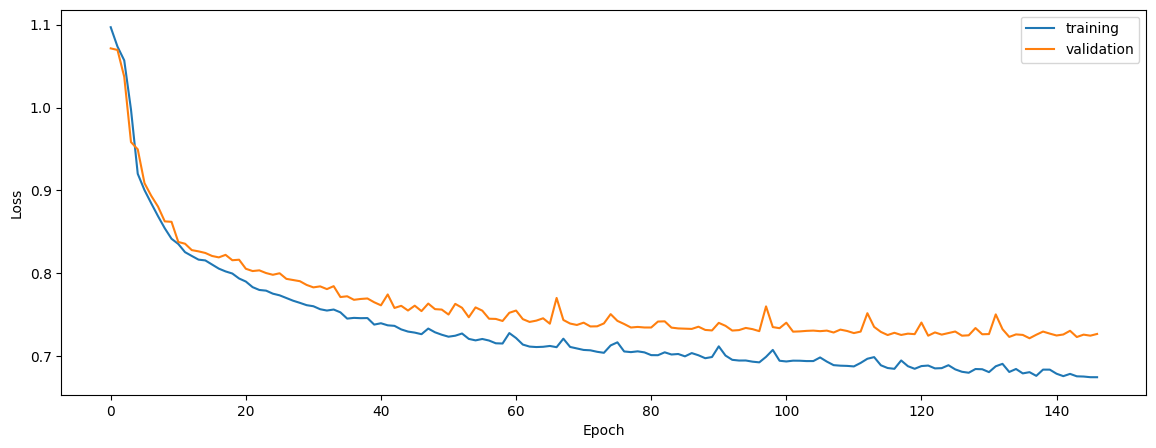

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.7077643288981237


0.6844822691289392


0.6947602745800593


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.7441193208764109


0.7116903902472247


0.7329305693269076


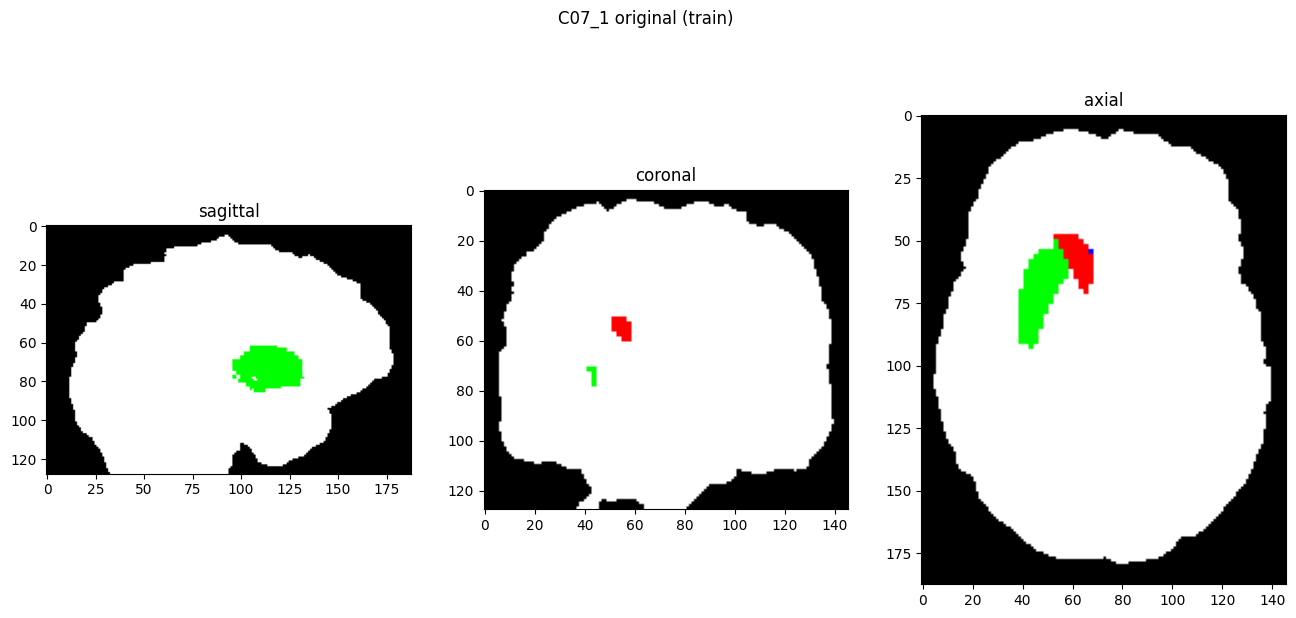

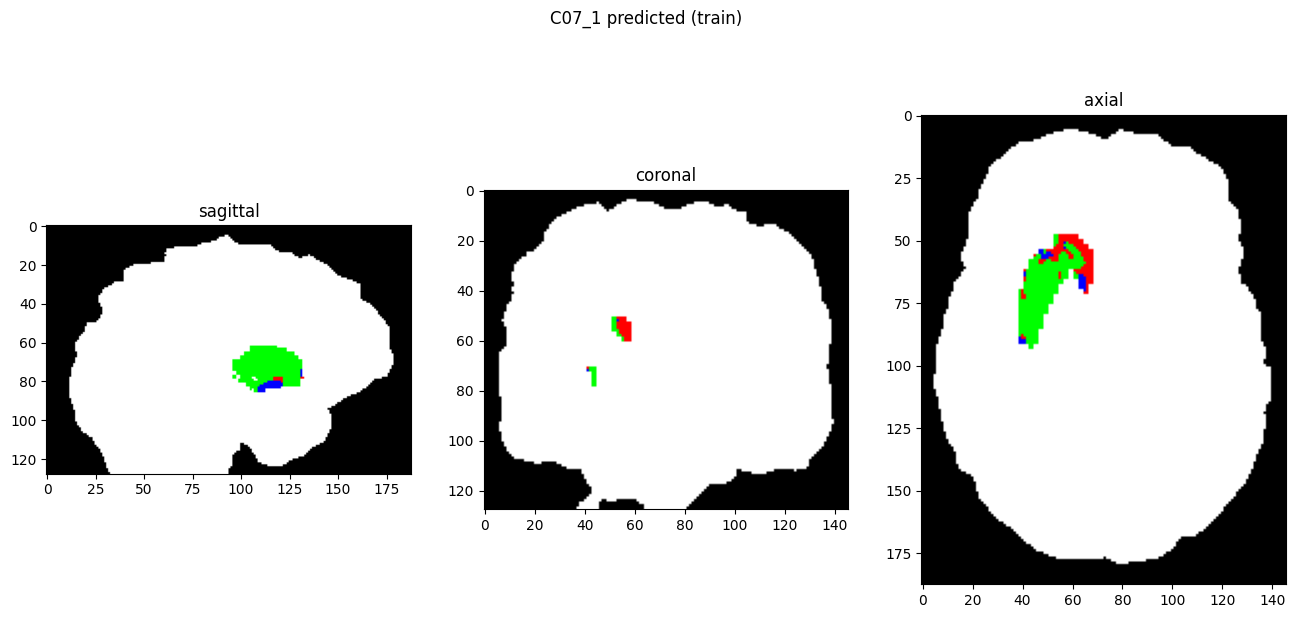

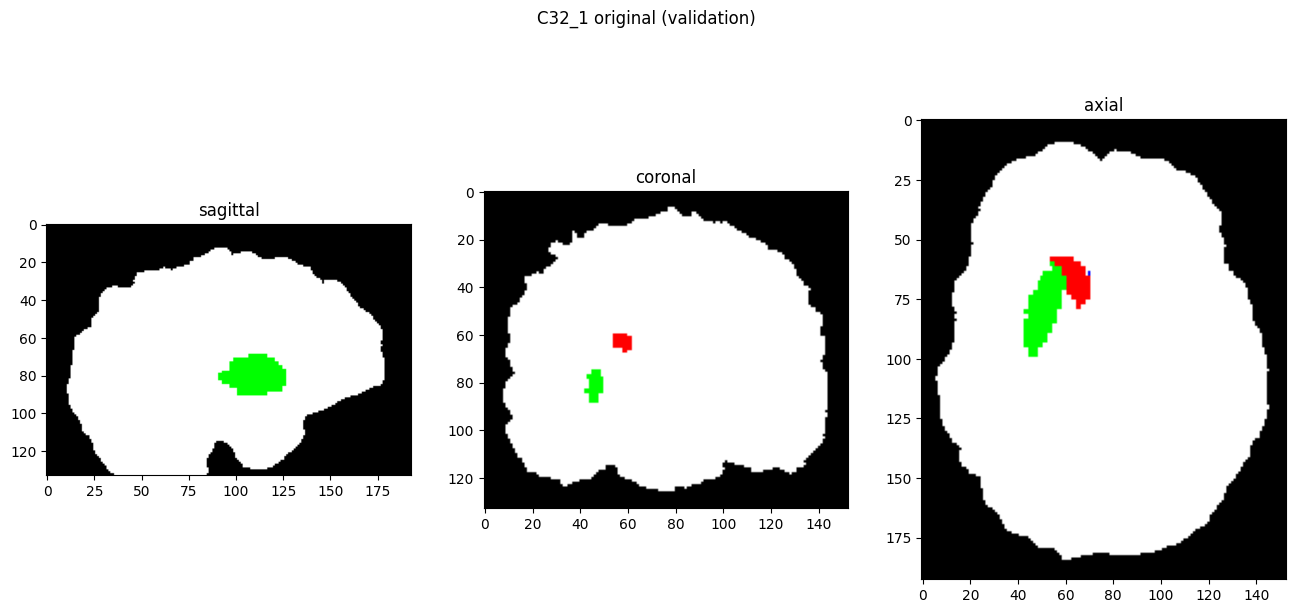

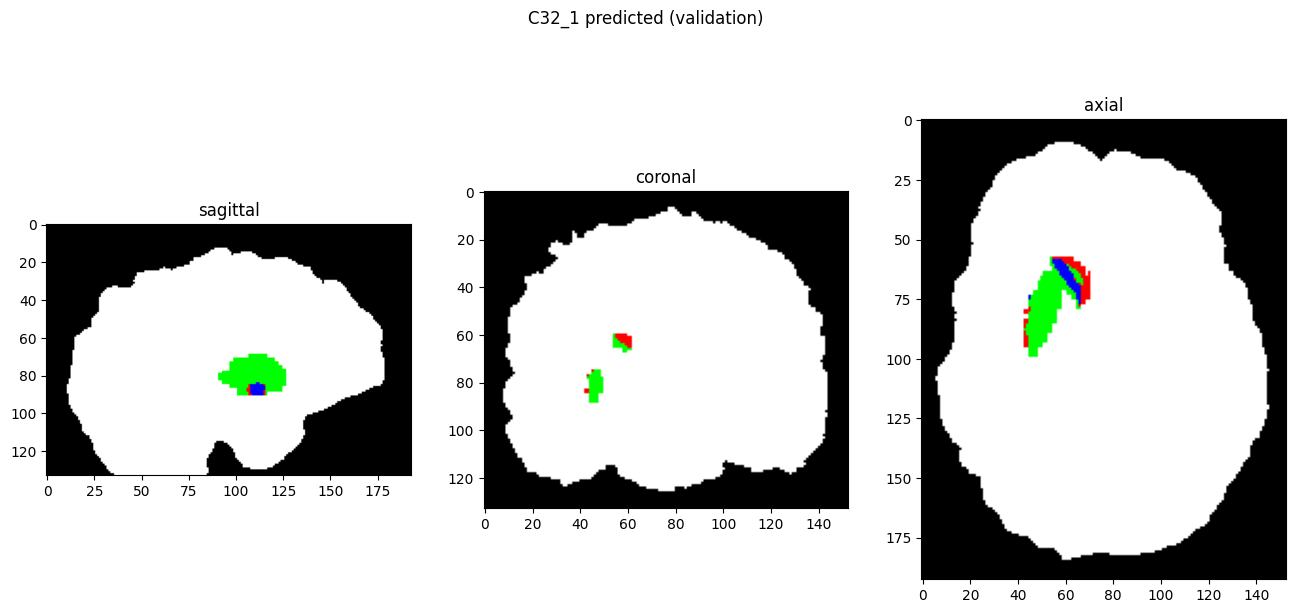

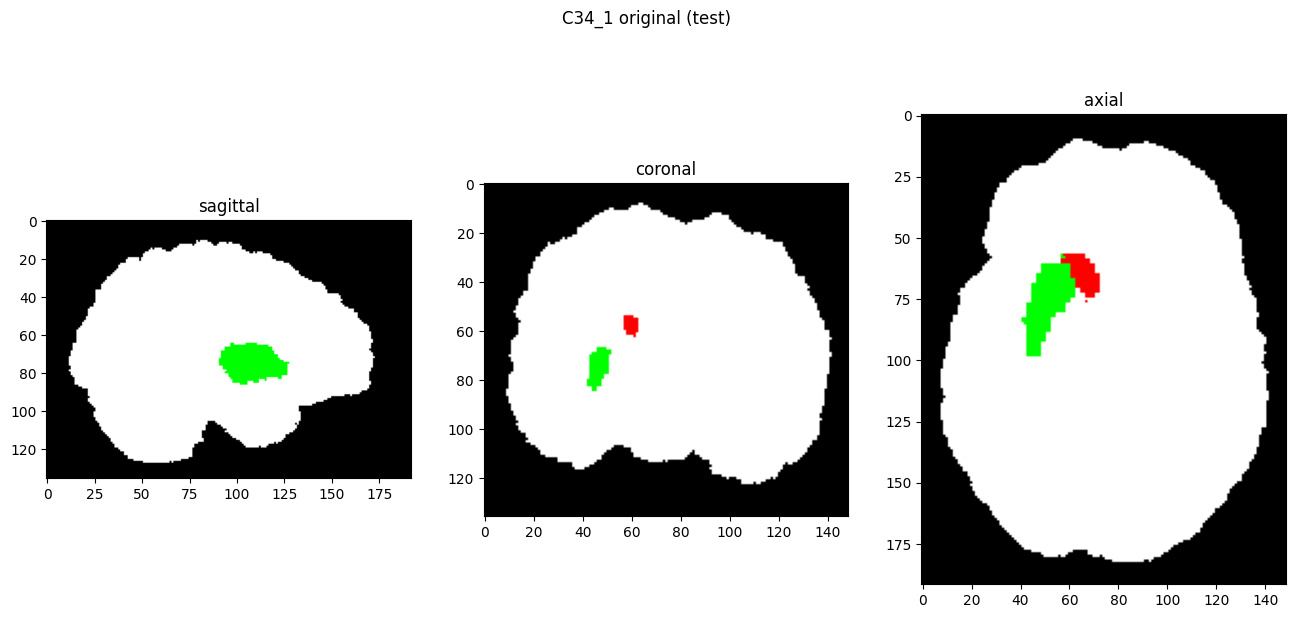

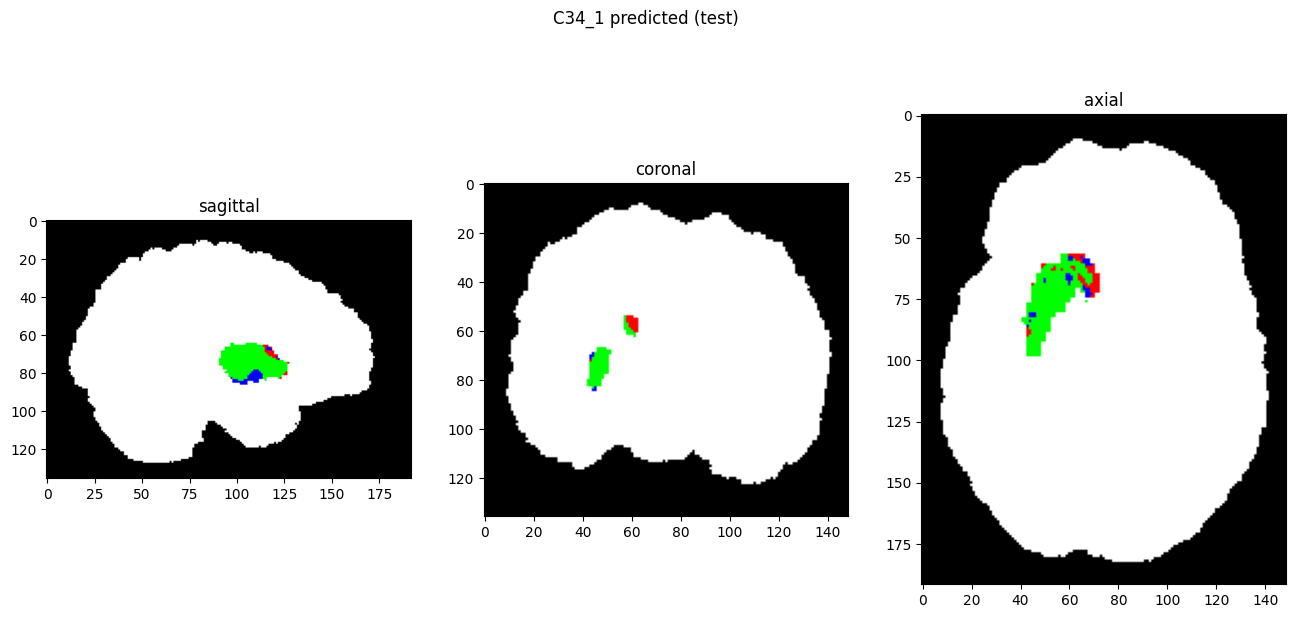

In [9]:
showResults(model, gen, threshold=0)